**Goal: find the regional glacier state in year 2020 and 2000 (based on Hugonnet et al. 2021 and Farinotti et al. 2019)**

- approach:
    - just to get the steady-state relative to 2020, it is relatively straight forward:
        - we scale all models first to match Farinotti at RGI date
        - we estimate the best estimate regional volume and divide by that instead of dividing through Farinotti (i.e., dividing through initial state of simulation year 0)
        - computationally we can just multiply by Farinotti and then divide by new 2020 volume
            - i.e., we can use the time scales relative to initial state and just multiply them with a factor that is  
                - scaling_factor =  Farinotti volume / 2020 volume 

In [1]:
# download it here https://cluster.klima.uni-bremen.de/~lschuster/glacierMIP3_analysis/glacierMIP3_{DATE}_models_all_rgi_regions_sum_scaled.nc
# and change the path to your local path
DATE = 'Feb12_2024' #'Jun29' 
fill_option = 'repeat_last_101yrs' #'repeat_last_20yrs'

# get weigthed median 
from statsmodels.stats.weightstats import DescrStatsW

import xarray as xr
import numpy as np
import pandas as pd
import scipy
import os
import glob
import matplotlib.pyplot as plt
from datetime import date
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
from moepy import lowess, eda

from matplotlib.lines import Line2D
import matplotlib.patches as mpatches
# for plots withinplots 
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from help_functions import pal_models, model_order, d_reg_num_name, model_order_anonymous

try:
    path_merged_runs_scaled_extend = f'/home/www/lschuster/glacierMIP3_analysis/glacierMIP3_{DATE}_models_all_rgi_regions_sum_scaled_extended_{fill_option}.nc'
    ds_reg_models = xr.open_dataset(path_merged_runs_scaled_extend)

except:
    path_merged_runs_scaled_extend = f'/home/lilianschuster/Downloads/glacierMIP3_{DATE}_models_all_rgi_regions_sum_scaled_extended_{fill_option}.nc'
    ds_reg_models = xr.open_dataset(path_merged_runs_scaled_extend)
    
# --> comes from isimip3b_postprocessing_analysis/isimip3b_postprocess_to_monthly.ipynb
pd_global_temp_exp = pd.read_csv('../data/temp_ch_ipcc_isimip3b.csv', index_col = 0)

hue_order_anonymous = []

pal_models_l = []
hue_order = []
for m, p in zip(model_order, pal_models):
    if (m!='OGGM-VAS') and (m!='OGGM_v153') and (m!='Huss'):
        hue_order.append(m)
        pal_models_l.append(p)
for m in hue_order:
    hue_order_anonymous.append(model_order_anonymous[m])
pal_models = pal_models_l

print(hue_order, hue_order_anonymous)
# select the right models:
ds_reg_models = ds_reg_models.sel(model_author = hue_order)
pal_models = sns.color_palette(pal_models)
pal_models

 
ds_reg_models = ds_reg_models.sel(model_author=hue_order)
ds_reg_models_vol = ds_reg_models.volume_m3

['PyGEM-OGGM_v13', 'GloGEMflow', 'GloGEMflow3D', 'OGGM_v16', 'GLIMB', 'Kraaijenbrink', 'GO', 'CISM2'] ['model 1', 'model 2', 'model 3', 'model 4', 'model 5', 'model 6', 'model 7', 'model 8']


In [2]:
def get_glob_temp_exp(region='global'):
    pd_global_temp_exp_glac = pd.read_csv('../data/temp_ch_ipcc_isimip3b_glacier_regionally.csv', index_col = 0)
    _p = pd_global_temp_exp_glac.loc[pd_global_temp_exp_glac.region == region]
    #print(_p.groupby(['gcm','period_scenario']).mean('temp_ch_ipcc'))
    _p = _p.groupby(['gcm','period_scenario']).mean('temp_ch_ipcc')
    return _p

In [3]:
pd_global_temp_exp_m  = get_glob_temp_exp(region='global')
pd_global_temp_exp_m

temp_ch_ipcc
gcm         period_scenario               
gfdl-esm4   1851-1870_hist        0.171409
            1901-1920_hist        0.418289
            1951-1970_hist        0.332281
            1995-2014_hist        0.841467
            2021-2040_ssp126      1.433792
...                                    ...
ukesm1-0-ll 2061-2080_ssp370      4.379977
            2061-2080_ssp585      5.170543
            2081-2100_ssp126      2.978482
            2081-2100_ssp370      5.780495
            2081-2100_ssp585      6.824361

[80 rows x 1 columns]

In [4]:
ds_reg_models_vol_stack = ds_reg_models_vol.stack(experiments=['gcm','period_scenario'])
pd_global_temp_exp_m = get_glob_temp_exp(region='global')
ds_reg_models_vol_stack = ds_reg_models_vol_stack.assign_coords(temp_ch_ipcc = ('experiments',
                                                                pd_global_temp_exp_m.loc[ds_reg_models_vol_stack.experiments, # make sure thatwe use the same experiments pd_global_temp_exp_m_glac
                                                                                   'temp_ch_ipcc']))
#ds_reg_models_vol_stack_above_08 = ds_reg_models_vol_stack.where(ds_reg_models_vol_stack.temp_ch_ipcc>=0.8).dropna(dim='experiments', how='all')

**get the regional volume changes according to Hugonnet et al. (2021)**

In [5]:
pd_hugonnet_ed_table_12 = pd.read_csv('data/data_from_others/hugonnet_et_al_2021_ED_table_1_2_data.csv')
# we compute it here once for the 20-year average, but decided later that we actually use the 5-yr avg. approach
pd_hugonnet_ed_table_12_20yrs = pd_hugonnet_ed_table_12.loc[pd_hugonnet_ed_table_12.period == '2000-01-01_2020-01-01']
pd_hugonnet_ed_table_12_20yrs_glob = pd_hugonnet_ed_table_12_20yrs.loc[pd_hugonnet_ed_table_12_20yrs.reg == 21] # Globally 
pd_hugonnet_ed_table_12_20yrs
np.testing.assert_allclose(pd_hugonnet_ed_table_12_20yrs['dmdt']/pd_hugonnet_ed_table_12_20yrs['dvoldt'], 8.5e-10, rtol=1e-3)
# the volume that is estimated by the glacier models is actually GLACIER OR ICE VOLUME?
# do we use the 900 factor to correct for it (or the 850 kg m-3that is used in Hugonnet!!!
#  or directly the vol_dt rates???
# discussed that with Fabien: we use here the vol_dt rates, however, for some model, like OGGM, 
# it would be more correct to use the Hugonnet mass changs (this is what OGGM models), and then convert to volume
# changes via the 900 conversion factor (instead of 850). ...
# ds_reg_models['mass_gt'] = ds_reg_models.volume_m3 * 900 * 1e-12 #kg m-3 , & kg to GT 

In [6]:
pd_hugonnet_ed_table_12

period         tarea   dhdt  err_dhdt        dvoldt  \
0    2000-01-01_2005-01-01  8.924625e+10 -0.652     0.060 -5.821064e+10   
1    2000-01-01_2020-01-01  8.608820e+10 -0.911     0.038 -7.841362e+10   
2    2005-01-01_2010-01-01  8.714090e+10 -0.802     0.056 -6.987370e+10   
3    2010-01-01_2015-01-01  8.503550e+10 -0.975     0.058 -8.294236e+10   
4    2015-01-01_2020-01-01  8.293015e+10 -1.238     0.054 -1.026278e+11   
..                     ...           ...    ...       ...           ...   
100  2000-01-01_2005-01-01  7.023358e+11 -0.380     0.019 -2.668219e+11   
101  2000-01-01_2020-01-01  6.852576e+11 -0.458     0.008 -3.136280e+11   
102  2005-01-01_2010-01-01  6.909503e+11 -0.438     0.016 -3.024432e+11   
103  2010-01-01_2015-01-01  6.795648e+11 -0.493     0.016 -3.349943e+11   
104  2015-01-01_2020-01-01  6.681792e+11 -0.524     0.017 -3.502528e+11   

       err_dvoldt      dmdt  err_dmdt  dmdtda  err_dmdtda  valid_obs  \
0    5.312934e+09  -49.4790    5.7090  -0.554       0.064       3.89   
1    3.199247e+09  -66.6516    5.4342  -0.774       0.064      28.62   
2    4.840451e+09  -59.3926    5.8741  -0.682       0.068       4.43   
3    4.830354e+09  -70.5010    6.4516  -0.829       0.076       6.91   
4    4.392788e+09  -87.2336    7.2013  -1.052       0.087      13.39   
..            ...       ...       ...     ...         ...        ...   
100  1.312605e+10 -226.7986   12.4906  -0.323       0.018       7.29   
101  5.307385e+09 -266.5838    7.9931  -0.389       0.012      39.21   
102  1.066688e+10 -257.0768   11.0414  -0.372       0.016       7.04   
103  1.054473e+10 -284.7451   11.4125  -0.419       0.017      10.99   
104  1.098014e+10 -297.7149   12.1149  -0.446       0.018      13.89   

     valid_obs_py   reg  perc_area_meas  perc_area_res  area_nodata  \
0            2.51   1.0           0.983          0.990   17684000.0   
1           11.50   1.0           0.983          0.990   17684000.0   
2            2.31   1.0           0.983          0.990   17684000.0   
3            2.33   1.0           0.983          0.990   17684000.0   
4            4.36   1.0           0.983          0.990   17684000.0   
..            ...   ...             ...            ...          ...   
100          3.13  21.0           0.967          0.973  999739000.0   
101         13.28  21.0           0.967          0.973  999739000.0   
102          2.98  21.0           0.967          0.973  999739000.0   
103          3.28  21.0           0.967          0.973  999739000.0   
104          3.89  21.0           0.967          0.973  999739000.0   

             area  
0    8.672505e+10  
1    8.672505e+10  
2    8.672505e+10  
3    8.672505e+10  
4    8.672505e+10  
..            ...  
100  7.059967e+11  
101  7.059967e+11  
102  7.059967e+11  
103  7.059967e+11  
104  7.059967e+11  

[105 rows x 17 columns]

In [7]:
import oggm
# get the RGI area / ITMIX volumes of the glaciers
rgi_regs = []
for rgi_reg in np.arange(1,20,1):
    if rgi_reg < 10:
        rgi_reg = '0'+str(rgi_reg)
    else:
        rgi_reg = str(rgi_reg)
    rgi_regs.append(rgi_reg)
df_itmix = pd.read_hdf(oggm.utils.get_demo_file('rgi62_itmix_df.h5'))

frgi = oggm.utils.file_downloader('https://cluster.klima.uni-bremen.de/~oggm/rgi/rgi62_stats.h5')
#frgi = '/home/users/lschuster/glacierMIP/rgi62_stats.h5'
odf = pd.read_hdf(frgi, index_col=0)
odf = odf.loc[(odf['Connect'] == 0) | (odf ['Connect'] ==1)]

pd_rgi_stats_w_hugonnet = pd.DataFrame(index=rgi_regs)
for rgi_reg in rgi_regs:
    # Greenland periphery : all glaciers with connectivity level 0 and 1 should be included, level 2 glaciers should be excluded (as was the case for GlacierMIP2)
    # total RGI area: 89,651km2
    rgidf = odf.loc[odf['O1Region'] == rgi_reg]
    
    
    years_rgi = np.array([int(x[:4]) for x in rgidf.BgnDate])
    area_rgi = rgidf.Area
    wq = DescrStatsW(data=years_rgi,
                     weights=area_rgi)
    med_weighted_yr = wq.quantile(probs=np.array([0.5]), return_pandas=False).squeeze()
    pd_rgi_stats_w_hugonnet.loc[rgi_reg,'rgi_year_weighted_median'] =  med_weighted_yr
    pd_rgi_stats_w_hugonnet.loc[rgi_reg,'regional_volume_m3_itmix'] = df_itmix.loc[rgidf.index]['vol_itmix_m3'].sum()
    
    yr_diff = 2020-med_weighted_yr
    if yr_diff>20:
        yr_diff = 20 # maximum 20 years!!! , as we don't know about the changes before year 2000
    pd_rgi_stats_w_hugonnet.loc[rgi_reg, 'yr_diff_rgi_vs_2020'] = yr_diff
    
    dvoldt = pd_hugonnet_ed_table_12_20yrs.loc[pd_hugonnet_ed_table_12_20yrs.reg == int(rgi_reg)]['dvoldt']
    pd_rgi_stats_w_hugonnet.loc[rgi_reg, 'dvoldt_m3_hugonnet'] = dvoldt.values
    for p in ['2000-01-01_2005-01-01', '2005-01-01_2010-01-01', '2010-01-01_2015-01-01', '2015-01-01_2020-01-01'][::-1]:
        dvoldt_p = pd_hugonnet_ed_table_12.loc[(pd_hugonnet_ed_table_12.period == p) & (pd_hugonnet_ed_table_12.reg == int(rgi_reg))]['dvoldt']
        pd_rgi_stats_w_hugonnet.loc[rgi_reg, f'dvoldt_m3_hugonnet_{p}'] = dvoldt_p.values

    _reg = rgidf['O1Region'].unique().squeeze()
    pd_rgi_stats_w_hugonnet.loc[rgi_reg, 'region'] = _reg
    
    loss_m3_p = 0
    yr_diff_reduced = yr_diff #.copy()
    for p in ['2000-01-01_2005-01-01', '2005-01-01_2010-01-01', '2010-01-01_2015-01-01', '2015-01-01_2020-01-01'][::-1]:
        if yr_diff_reduced <=5:
            loss_m3_p += pd_rgi_stats_w_hugonnet.loc[rgi_reg, f'dvoldt_m3_hugonnet_{p}'] * yr_diff_reduced
            break
        else:
            loss_m3_p += pd_rgi_stats_w_hugonnet.loc[rgi_reg, f'dvoldt_m3_hugonnet_{p}'] * 5 
            yr_diff_reduced -= 5 # reduce it by 5 years
    pd_rgi_stats_w_hugonnet.loc[rgi_reg, 'loss_m3_via_5yravg'] = loss_m3_p
    
    ### same for the "gain" until 2000
    gain_m3_p = 0
    yr_diff_reduced_gain = 20-yr_diff #.copy()
    for p in ['2000-01-01_2005-01-01', '2005-01-01_2010-01-01', '2010-01-01_2015-01-01', '2015-01-01_2020-01-01']:
        if yr_diff_reduced_gain <=5:
            gain_m3_p -= pd_rgi_stats_w_hugonnet.loc[rgi_reg, f'dvoldt_m3_hugonnet_{p}'] * yr_diff_reduced_gain
            break
        else:
            gain_m3_p -= pd_rgi_stats_w_hugonnet.loc[rgi_reg, f'dvoldt_m3_hugonnet_{p}'] * 5 
            yr_diff_reduced_gain -= 5 # reduce it by 5 years
    pd_rgi_stats_w_hugonnet.loc[rgi_reg, 'gain_m3_via_5yravg'] = gain_m3_p


loss_m3 = pd_rgi_stats_w_hugonnet['dvoldt_m3_hugonnet'] * pd_rgi_stats_w_hugonnet['yr_diff_rgi_vs_2020']
gain_m3 = -pd_rgi_stats_w_hugonnet['dvoldt_m3_hugonnet'] * (20-pd_rgi_stats_w_hugonnet['yr_diff_rgi_vs_2020']) 

approach = '_via_5yravg'
pd_rgi_stats_w_hugonnet[f'regional_volume_m3_2020{approach}'] = pd_rgi_stats_w_hugonnet['regional_volume_m3_itmix'] + pd_rgi_stats_w_hugonnet['loss_m3_via_5yravg']
# negative because it is a gain as the inventory date is defined to be at yr 2000 or afterwards
pd_rgi_stats_w_hugonnet[f'regional_volume_m3_2000{approach}'] = pd_rgi_stats_w_hugonnet['regional_volume_m3_itmix'] + pd_rgi_stats_w_hugonnet['gain_m3_via_5yravg']

approach = '_via_20yravg' #'_avg_20yr'
pd_rgi_stats_w_hugonnet[f'regional_volume_m3_2020{approach}'] = pd_rgi_stats_w_hugonnet['regional_volume_m3_itmix'] + loss_m3
# negative because it is a gain as the inventory date is defined to be at yr 2000 or afterwards
pd_rgi_stats_w_hugonnet[f'regional_volume_m3_2000{approach}'] = pd_rgi_stats_w_hugonnet['regional_volume_m3_itmix'] + gain_m3

# estimate it globally by summing over the regional 2020 estimates to first get a global estimate for 2020
pd_rgi_stats_w_hugonnet.loc['Globally', 'region'] = 'Globally'
for approach in ['_via_5yravg', '_via_20yravg']:
    pd_rgi_stats_w_hugonnet.loc['Globally', f'regional_volume_m3_2020{approach}'] = pd_rgi_stats_w_hugonnet[f'regional_volume_m3_2020{approach}'].sum()
    pd_rgi_stats_w_hugonnet.loc['Globally', f'regional_volume_m3_2000{approach}'] = pd_rgi_stats_w_hugonnet[f'regional_volume_m3_2000{approach}'].sum()
pd_rgi_stats_w_hugonnet.loc['Globally', 'regional_volume_m3_itmix'] = pd_rgi_stats_w_hugonnet['regional_volume_m3_itmix'].sum()
pd_rgi_stats_w_hugonnet.loc['Globally', 'dvoldt_m3_hugonnet'] = pd_hugonnet_ed_table_12_20yrs_glob['dvoldt'].values
# also compute median weigted global RGI year
years_rgi = np.array([int(x[:4]) for x in odf.BgnDate])
area_rgi = odf.Area
wq = DescrStatsW(data=years_rgi,
                 weights=area_rgi)
med_weighted_yr = wq.quantile(probs=np.array([0.5]), return_pandas=False).squeeze()
pd_rgi_stats_w_hugonnet.loc['Globally','rgi_year_weighted_median'] =  med_weighted_yr
yr_diff = 2020-med_weighted_yr
if yr_diff>20:
    yr_diff = 20 # maximum 20 years!!! , as we don't know about the changes before year 2000
pd_rgi_stats_w_hugonnet.loc['Globally', 'yr_diff_rgi_vs_2020'] = yr_diff
for approach in ['_via_5yravg', '_via_20yravg']:
    pd_rgi_stats_w_hugonnet['regional_volume_m3_itmix_vs_2020'] = pd_rgi_stats_w_hugonnet['regional_volume_m3_itmix']/pd_rgi_stats_w_hugonnet[f'regional_volume_m3_2020{approach}']
    pd_rgi_stats_w_hugonnet['regional_volume_m3_itmix_vs_2000'] = pd_rgi_stats_w_hugonnet['regional_volume_m3_itmix']/pd_rgi_stats_w_hugonnet[f'regional_volume_m3_2000{approach}']

    pd_rgi_stats_w_hugonnet[f'regional_dvol_dt_2000_2019_vs_2020_vol{approach}'] = pd_rgi_stats_w_hugonnet['dvoldt_m3_hugonnet']/pd_rgi_stats_w_hugonnet[f'regional_volume_m3_2020{approach}']
    pd_rgi_stats_w_hugonnet[f'regional_dvol_dt_2000_2019_vs_2000_vol{approach}'] = pd_rgi_stats_w_hugonnet['dvoldt_m3_hugonnet']/pd_rgi_stats_w_hugonnet[f'regional_volume_m3_2000{approach}']

In [8]:
np.testing.assert_allclose(pd_rgi_stats_w_hugonnet['regional_volume_m3_2020_via_20yravg'],
                           pd_rgi_stats_w_hugonnet['regional_volume_m3_2020_via_5yravg'], rtol = 0.025)
np.testing.assert_allclose(pd_rgi_stats_w_hugonnet['regional_volume_m3_2000_via_20yravg'],
                           pd_rgi_stats_w_hugonnet['regional_volume_m3_2000_via_5yravg'], rtol = 0.02)
#TODO make tests with a few regions if the approach actually works !!!

In [9]:
pd_rgi_stats_w_hugonnet

rgi_year_weighted_median  regional_volume_m3_itmix  \
01                          2010.0              1.897846e+13   
02                          2004.0              1.046788e+12   
03                          1999.0              2.833124e+13   
04                          2001.0              8.611335e+12   
05                          2001.0              1.569203e+13   
06                          2000.0              3.769574e+12   
07                          2008.0              7.470376e+12   
08                          2002.0              2.985090e+11   
09                          2001.0              1.464022e+13   
10                          2011.0              1.357811e+11   
11                          2003.0              1.279243e+11   
12                          2001.0              6.307984e+10   
13                          2007.0              3.270827e+12   
14                          2001.0              2.865118e+12   
15                          2002.0              8.773130e+11   
16                          2000.0              9.836315e+10   
17                          2000.0              5.339819e+12   
18                          1978.0              7.369536e+10   
19                          1986.0              4.646614e+13   
Globally                    2000.0              1.581566e+14   

          yr_diff_rgi_vs_2020  dvoldt_m3_hugonnet  \
01                       10.0       -7.841362e+10   
02                       16.0       -8.894468e+09   
03                       20.0       -3.595335e+10   
04                       19.0       -3.117858e+10   
05                       19.0       -4.178265e+10   
06                       20.0       -1.101284e+10   
07                       12.0       -1.239900e+10   
08                       18.0       -1.961838e+09   
09                       19.0       -1.224699e+10   
10                        9.0       -1.479667e+09   
11                       17.0       -1.988682e+09   
12                       19.0       -7.919494e+08   
13                       13.0       -1.129933e+10   
14                       19.0       -5.360179e+09   
15                       18.0       -8.088041e+09   
16                       20.0       -1.097299e+09   
17                       20.0       -2.434047e+10   
18                       20.0       -7.652857e+08   
19                       20.0       -2.457380e+10   
Globally                 20.0       -3.136280e+11   

          dvoldt_m3_hugonnet_2015-01-01_2020-01-01  \
01                                   -1.026278e+11   
02                                   -1.444629e+10   
03                                   -3.397691e+10   
04                                   -3.513663e+10   
05                                   -3.649135e+10   
06                                   -7.935130e+09   
07                                   -1.857601e+10   
08                                   -1.584180e+09   
09                                   -1.537172e+10   
10                                   -1.637005e+09   
11                                   -2.010327e+09   
12                                   -1.150109e+09   
13                                   -1.876946e+10   
14                                   -7.255956e+09   
15                                   -9.358133e+09   
16                                   -1.139839e+09   
17                                   -2.783116e+10   
18                                   -1.284622e+09   
19                                   -1.367013e+10   
Globally                                       NaN   

          dvoldt_m3_hugonnet_2010-01-01_2015-01-01  \
01                                   -8.294236e+10   
02                                   -1.071820e+10   
03                                   -4.138025e+10   
04                                   -3.412745e+10   
05                                   -4.607979e+10   
06                                   -1.022784e+10   
07                                   -

In [10]:
# test for RGI11
rgi_reg = '11'
pd_rgi_stats_w_hugonnet_reg = pd_rgi_stats_w_hugonnet.loc[rgi_reg]
rgi_yr = pd_rgi_stats_w_hugonnet_reg['rgi_year_weighted_median']
yr_diff = 2020 - rgi_yr
print(yr_diff, rgi_reg)
assert np.all(yr_diff == pd_rgi_stats_w_hugonnet_reg['yr_diff_rgi_vs_2020'])
sum_20yr_from5yr = (pd_rgi_stats_w_hugonnet_reg['dvoldt_m3_hugonnet_2015-01-01_2020-01-01']*5 + pd_rgi_stats_w_hugonnet_reg['dvoldt_m3_hugonnet_2010-01-01_2015-01-01']*5 + 
 pd_rgi_stats_w_hugonnet_reg['dvoldt_m3_hugonnet_2005-01-01_2010-01-01']*5 + pd_rgi_stats_w_hugonnet_reg['dvoldt_m3_hugonnet_2000-01-01_2005-01-01']*5)
np.testing.assert_allclose(pd_rgi_stats_w_hugonnet_reg['dvoldt_m3_hugonnet']*20 , sum_20yr_from5yr)

sum_17yr_from5yr = (pd_rgi_stats_w_hugonnet_reg['dvoldt_m3_hugonnet_2015-01-01_2020-01-01']*5 + pd_rgi_stats_w_hugonnet_reg['dvoldt_m3_hugonnet_2010-01-01_2015-01-01']*5 + 
 pd_rgi_stats_w_hugonnet_reg['dvoldt_m3_hugonnet_2005-01-01_2010-01-01']*5 + pd_rgi_stats_w_hugonnet_reg['dvoldt_m3_hugonnet_2000-01-01_2005-01-01']*2)
# this should be exactly the same as the approach applied above 
np.testing.assert_allclose(pd_rgi_stats_w_hugonnet_reg['loss_m3_via_5yravg'], sum_17yr_from5yr)
np.testing.assert_allclose(pd_rgi_stats_w_hugonnet_reg['dvoldt_m3_hugonnet']*17 , sum_17yr_from5yr, rtol = 0.01) # 0.025)
# for the gain, we just need in this test case 3 years 
np.testing.assert_allclose(-pd_rgi_stats_w_hugonnet_reg['dvoldt_m3_hugonnet_2000-01-01_2005-01-01']*3, pd_rgi_stats_w_hugonnet_reg['gain_m3_via_5yravg'])

# test for RGI10
rgi_reg = '10'
pd_rgi_stats_w_hugonnet_reg = pd_rgi_stats_w_hugonnet.loc[rgi_reg]
rgi_yr = pd_rgi_stats_w_hugonnet_reg['rgi_year_weighted_median']
yr_diff = 2020 - rgi_yr
print(yr_diff, rgi_reg)
assert np.all(yr_diff == pd_rgi_stats_w_hugonnet_reg['yr_diff_rgi_vs_2020'])
sum_20yr_from5yr = (pd_rgi_stats_w_hugonnet_reg['dvoldt_m3_hugonnet_2015-01-01_2020-01-01']*5 + pd_rgi_stats_w_hugonnet_reg['dvoldt_m3_hugonnet_2010-01-01_2015-01-01']*5 + 
 pd_rgi_stats_w_hugonnet_reg['dvoldt_m3_hugonnet_2005-01-01_2010-01-01']*5 + pd_rgi_stats_w_hugonnet_reg['dvoldt_m3_hugonnet_2000-01-01_2005-01-01']*5)
np.testing.assert_allclose(pd_rgi_stats_w_hugonnet_reg['dvoldt_m3_hugonnet']*20 , sum_20yr_from5yr)

sum_9yr_from5yr = (pd_rgi_stats_w_hugonnet_reg['dvoldt_m3_hugonnet_2015-01-01_2020-01-01']*5 + pd_rgi_stats_w_hugonnet_reg['dvoldt_m3_hugonnet_2010-01-01_2015-01-01']*4 + 
 pd_rgi_stats_w_hugonnet_reg['dvoldt_m3_hugonnet_2005-01-01_2010-01-01']*0 + pd_rgi_stats_w_hugonnet_reg['dvoldt_m3_hugonnet_2000-01-01_2005-01-01']*0)
# this should be exactly the same as the approach applied above 
np.testing.assert_allclose(pd_rgi_stats_w_hugonnet_reg['loss_m3_via_5yravg'], sum_9yr_from5yr)
np.testing.assert_allclose(pd_rgi_stats_w_hugonnet_reg['dvoldt_m3_hugonnet']*9 , sum_9yr_from5yr, rtol = 0.08)  # this is higher 
# for the gain, we just need in this test case 3 years 
np.testing.assert_allclose(-pd_rgi_stats_w_hugonnet_reg['dvoldt_m3_hugonnet_2000-01-01_2005-01-01']*5 -pd_rgi_stats_w_hugonnet_reg['dvoldt_m3_hugonnet_2005-01-01_2010-01-01']*5 - pd_rgi_stats_w_hugonnet_reg['dvoldt_m3_hugonnet_2010-01-01_2015-01-01']*1,
                           pd_rgi_stats_w_hugonnet_reg['gain_m3_via_5yravg'])

17.0 11
9.0 10


Text(0.5, 1.0, 'regional volume approach comparisons')

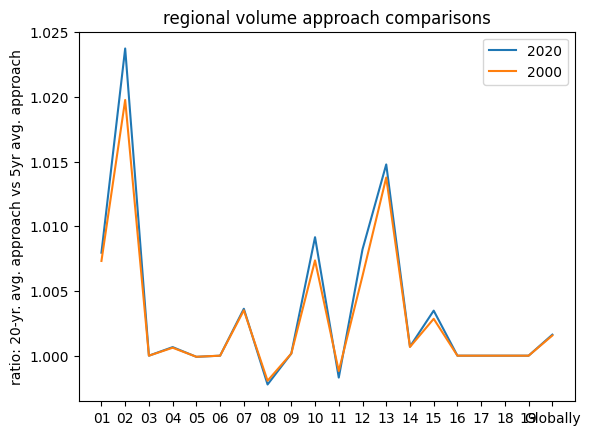

In [11]:
plt.plot(pd_rgi_stats_w_hugonnet['regional_volume_m3_2020_via_20yravg']/pd_rgi_stats_w_hugonnet['regional_volume_m3_2020_via_5yravg'], label='2020')
plt.ylabel('ratio: 20-yr. avg. approach vs 5yr avg. approach')
plt.plot(pd_rgi_stats_w_hugonnet['regional_volume_m3_2000_via_20yravg']/pd_rgi_stats_w_hugonnet['regional_volume_m3_2000_via_5yravg'], label = '2000')
plt.ylabel('ratio: 20-yr. avg. approach vs 5yr avg. approach')

plt.legend()

plt.title('regional volume approach comparisons')

In [12]:
pd_rgi_stats_w_hugonnet.to_csv(f'rgi_vs_2020_volume_hugonnet_estimates{DATE}.csv') # regional_volume_m3_itmix_vs_2020 is the scaling factor that we have to multiply to all the relative time series!!!

- according to Hugonnet et al. estimates 3% compared to Farinotti got removed until 2020 globally. In RGI11 it is 36% (also a lot in RGI12, RGI16 and RGI18), in RGI09, RGI03 and RGI19, it is only 1 %
    - when accounting for the RGI year differences, we can instead look at the regional volume differences relative to the 2020 volume, and there we see e.g. 2% relative to 2020 volume lost in RGI11
    - Luckily, globally the RGI median area-weigted is year 2000 ...

## Create shifted timeseries netcdf 

In [13]:
approach = '_via_5yravg'

dict_model_col = {}
for c,m in zip(pal_models, hue_order):
    dict_model_col[m] = c
# allow a maximum shift of 50 years
max_year_shift = 50
# volume relative to 2020 (this is the important conversion for the steady-state analysis)
ds_reg_models_vol_rel_2020 = 100*ds_reg_models_vol_stack/pd_rgi_stats_w_hugonnet.loc[ds_reg_models_vol_stack.rgi_reg][f'regional_volume_m3_2020{approach}'].values.reshape(1,19,1,1)
#  find the year where the volume is nearest to the 2020 volume (i.e., nearest to the perc_ideal of 100)
perc_ideal = 100
yrs_w_most_similar_state = np.abs(ds_reg_models_vol_rel_2020.sel(simulation_year=slice(0,max_year_shift))-perc_ideal).idxmin(dim='simulation_year')
#starting_vol_most_similar_state = np.abs(ds_reg_models_vol_rel_2020_above_08.sel(simulation_year=slice(0,100))-100).idxmin(dim='simulation_year')
ds_reg_models_vol_rel_2020 = ds_reg_models_vol_rel_2020.assign_coords(yrs_w_most_similar_state_to_2020 = (['model_author','rgi_reg','experiments'],
                                              yrs_w_most_similar_state.data))
# make sure that the array has the right format -> then reshape to include again the "simulation year" dimension
assert np.shape(ds_reg_models_vol_rel_2020['yrs_w_most_similar_state_to_2020'].values) == (8,19,80)
new_start_yr = ds_reg_models_vol_rel_2020.simulation_year.data.reshape(1,1,5001,1) - ds_reg_models_vol_rel_2020['yrs_w_most_similar_state_to_2020'].data.reshape(8,19,1,80) # 8 glacier models
ds_reg_models_vol_rel_2020 = ds_reg_models_vol_rel_2020.assign_coords(year_after_2020 = (['model_author','rgi_reg',
                                                                                                            'simulation_year','experiments'],
                                              new_start_yr))

_ds_t_l = []
for rgi_reg in ds_reg_models_vol_rel_2020.rgi_reg:
    ### it is too slow if we don't do it for every region separately ... 
    _p_test = ds_reg_models_vol_rel_2020.sel(rgi_reg=rgi_reg).to_dataframe().reset_index()
    #_p_test = _p_test.loc[_p_test.new_start_yr>=0]
    _ds_t = _p_test.groupby(['model_author','rgi_reg','year_after_2020','period_scenario','gcm']).mean().to_xarray()
    _ds_t = _ds_t.rename_vars({'volume_m3':'volume_rel_2020_%'})
    _ds_t_l.append(_ds_t)
    #print(rgi_reg.values)
    #_ds_t = _ds_t.sel(year_after_2020=slice(0,4900))
ds_reg_yr_shift = xr.concat(_ds_t_l, dim='rgi_reg')


In [14]:
_convert = pd_rgi_stats_w_hugonnet.loc[ds_reg_models_vol_stack.rgi_reg][f'regional_volume_m3_2020{approach}'].values.reshape(1,19,1,1,1)
ds_reg_yr_shift['volume_m3'] = ds_reg_yr_shift['volume_rel_2020_%'] * _convert/100
_glob_vol_test = ds_reg_yr_shift['volume_m3'].sel(year_after_2020=0).median(dim='model_author').sum(dim='rgi_reg')
# above 08 should match better t
_glob_vol_test_ab_08 = _glob_vol_test.sel(period_scenario=pd_global_temp_exp.loc[pd_global_temp_exp.temp_ch_ipcc>=0.8].period_scenario.unique())
np.testing.assert_allclose(_glob_vol_test_ab_08, pd_rgi_stats_w_hugonnet.loc['Globally', f'regional_volume_m3_2020{approach}'], rtol=4e-3)
np.testing.assert_allclose(_glob_vol_test, pd_rgi_stats_w_hugonnet.loc['Globally', f'regional_volume_m3_2020{approach}'], rtol=3e-2)

above 0.8°C, the volume is globally matched well (within 0.5%):

In [15]:
((np.abs(_glob_vol_test_ab_08-pd_rgi_stats_w_hugonnet.loc['Globally',
                                                   f'regional_volume_m3_2020{approach}']))/pd_rgi_stats_w_hugonnet.loc['Globally',
                                                                                                            f'regional_volume_m3_2020{approach}']).max()

<xarray.DataArray 'volume_m3' ()>
array(0.0033168)
Coordinates:
    year_after_2020  float64 0.0

below 0.8°C: maximum ~2.5% globally off 

In [16]:
((np.abs(_glob_vol_test-pd_rgi_stats_w_hugonnet.loc['Globally',
                                                   f'regional_volume_m3_2020{approach}']))/pd_rgi_stats_w_hugonnet.loc['Globally',
                                                                                                            f'regional_volume_m3_2020{approach}']).max()

<xarray.DataArray 'volume_m3' ()>
array(0.02501124)
Coordinates:
    year_after_2020  float64 0.0

**ok, after the tests, we are ready to save the netcdf files**:

In [17]:
ds_reg_yr_shift.to_netcdf(f'/home/www/lschuster/glacierMIP3_analysis/all_shifted_glacierMIP3_{DATE}_models_all_rgi_regions_sum_scaled_extended_{fill_option}{approach}.nc')

In [18]:
ds_reg_yr_shift

<xarray.Dataset>
Dimensions:                           (model_author: 8, rgi_reg: 19,
                                       year_after_2020: 5051,
                                       period_scenario: 16, gcm: 5)
Coordinates:
  * model_author                      (model_author) object 'CISM2' ... 'PyGE...
  * rgi_reg                           (rgi_reg) object '01' '02' ... '18' '19'
  * year_after_2020                   (year_after_2020) float64 -50.0 ... 5e+03
  * period_scenario                   (period_scenario) object '1851-1870_his...
  * gcm                               (gcm) object 'gfdl-esm4' ... 'ukesm1-0-ll'
Data variables:
    simulation_year                   (model_author, rgi_reg, year_after_2020, period_scenario, gcm) float64 ...
    temp_ch_ipcc                      (model_author, rgi_reg, year_after_2020, period_scenario, gcm) float64 ...
    yrs_w_most_similar_state_to_2020  (model_author, rgi_reg, year_after_2020, period_scenario, gcm) float64 ...
    volume_rel_2020_%                 (model_author, rgi_reg, year_after_2020, period_scenario, gcm) float64 ...
    volume_m3                         (model_author, rgi_reg, year_after_2020, period_scenario, gcm) float64 ...

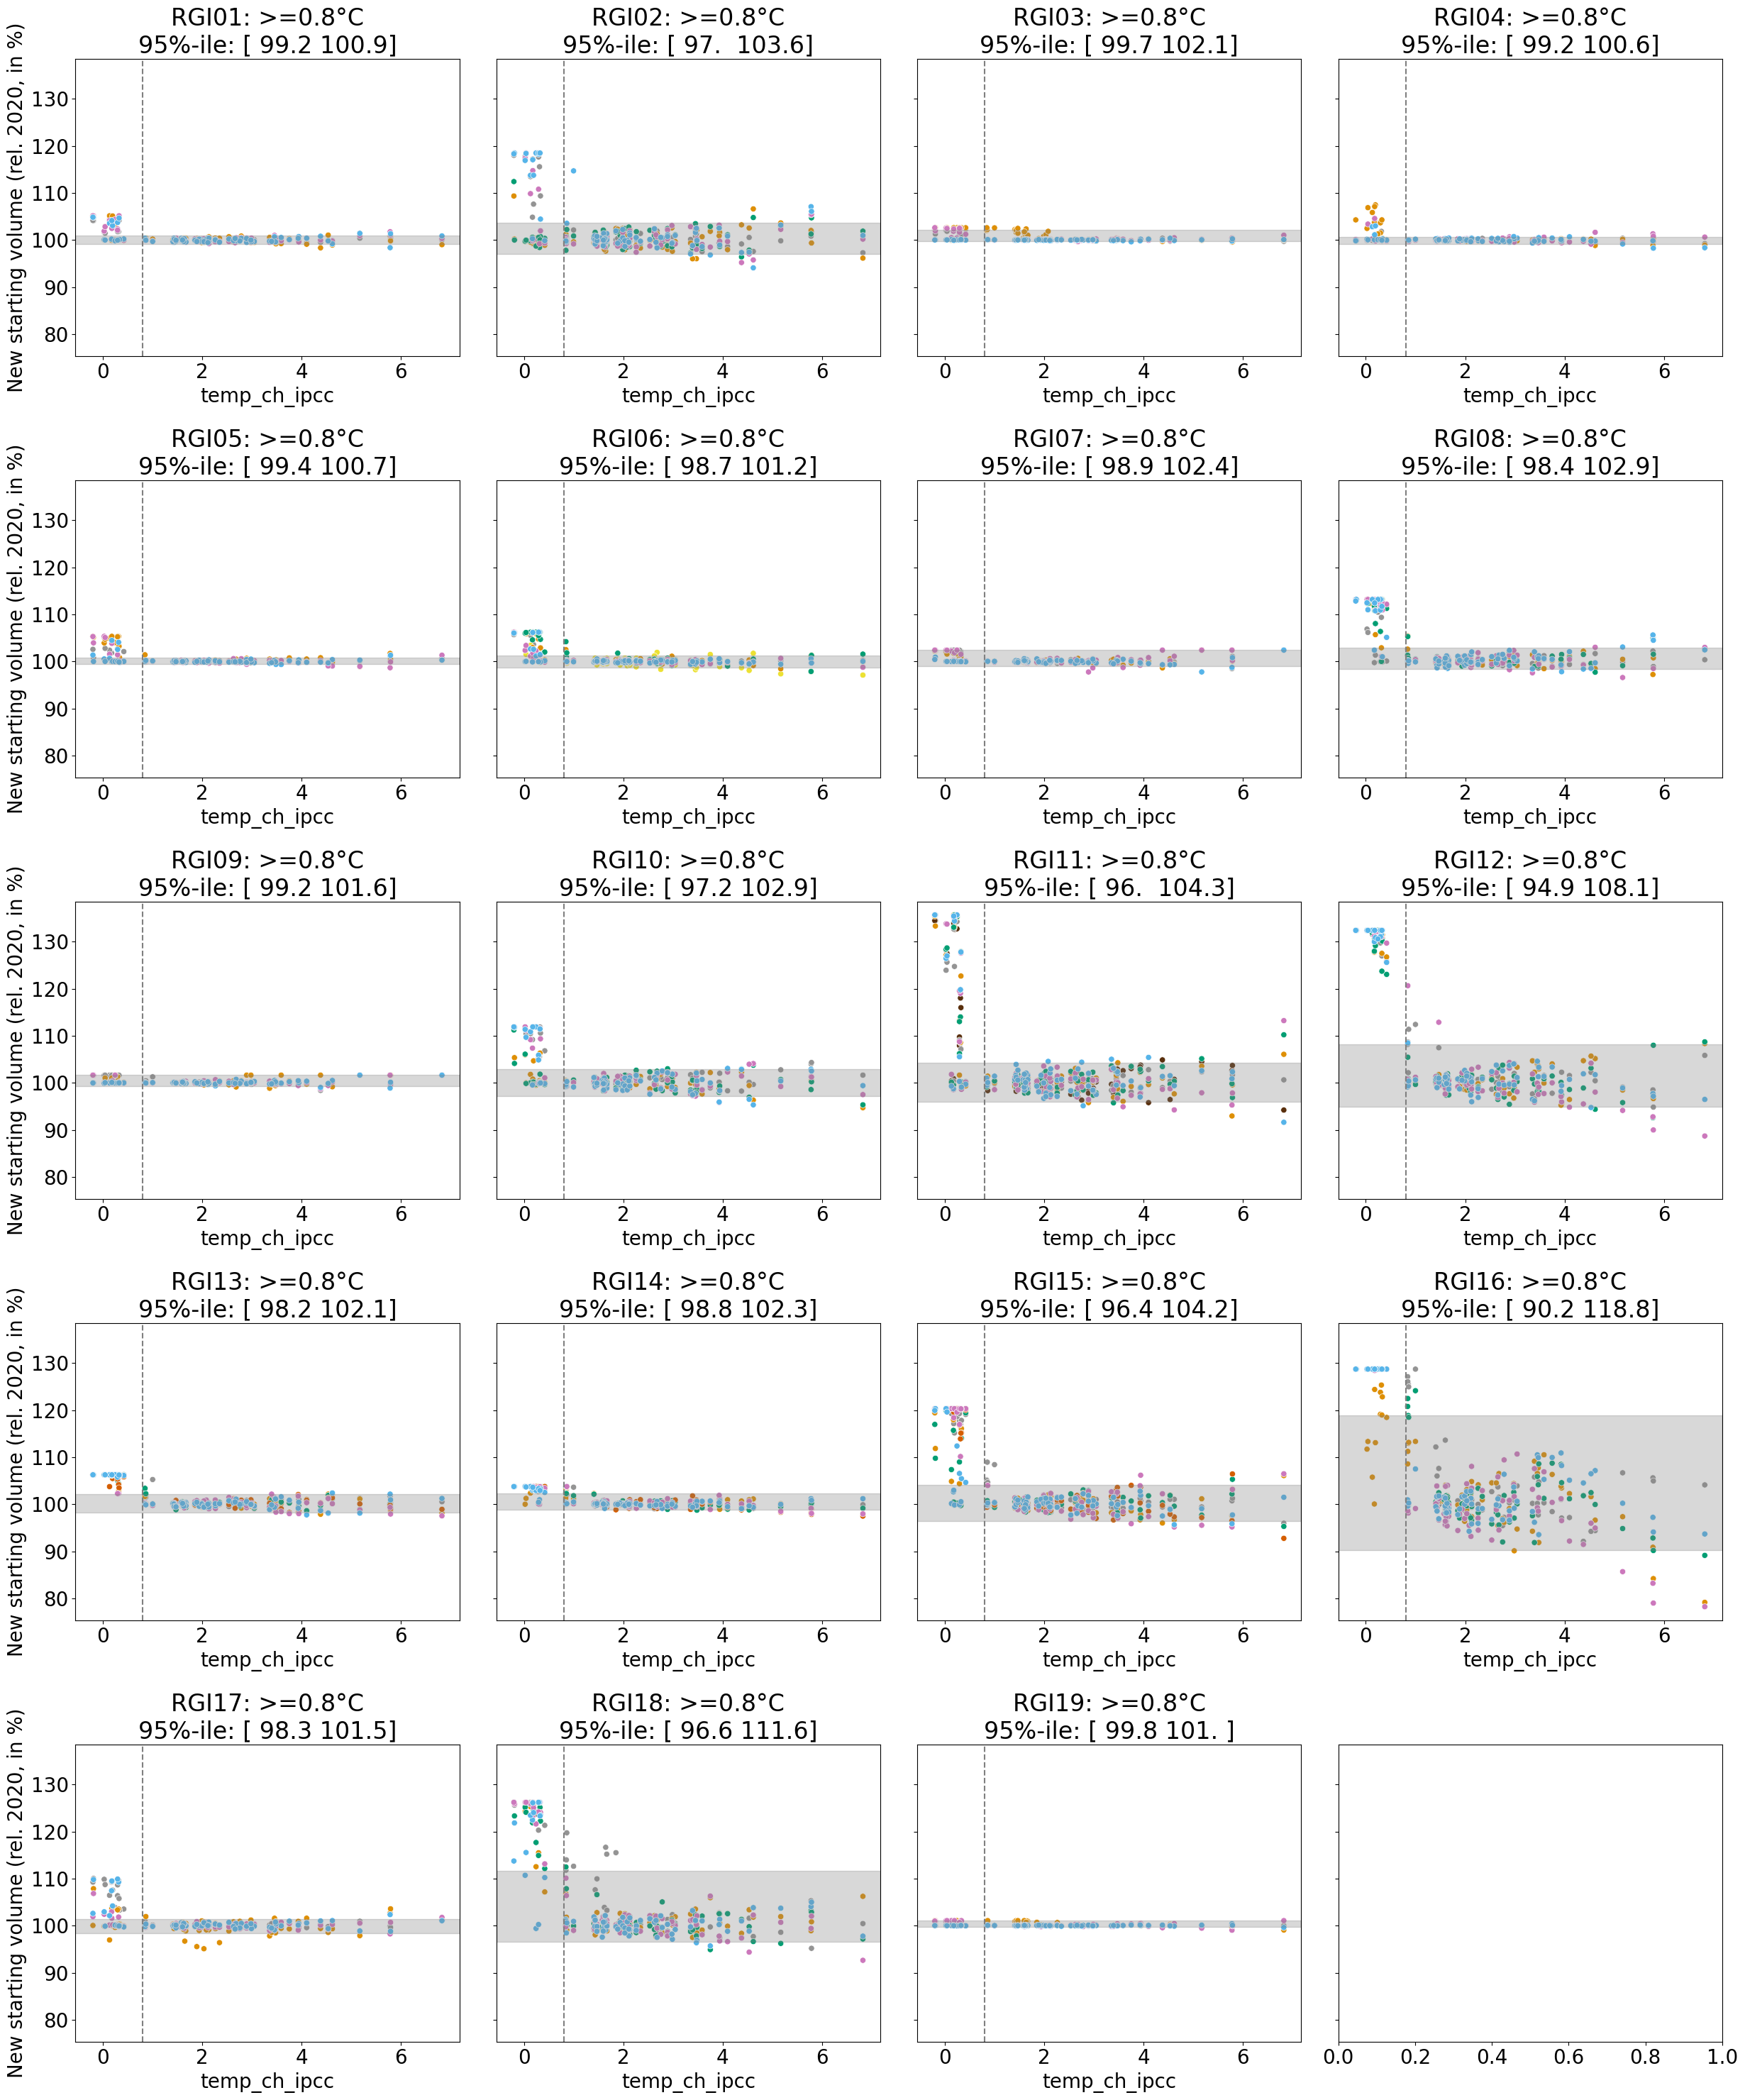

In [19]:
plt.rc('font', size=20)  

fig, axs = plt.subplots(5,4,figsize=(25,30), sharey=True)
axs = axs.flatten()

for j,rgi_reg in enumerate(ds_reg_yr_shift.rgi_reg.values):
    _t = ds_reg_yr_shift.sel(year_after_2020=0).sel(rgi_reg=rgi_reg)['volume_rel_2020_%']
    #print(rgi_reg, _t.quantile([0,0.01,0.02,0.98,0.99,1]).values)
    ax = axs[j]
    sns.scatterplot(data=ds_reg_yr_shift.sel(year_after_2020=0).sel(rgi_reg=rgi_reg).to_dataframe().reset_index().dropna(),
                x='temp_ch_ipcc',
                y='volume_rel_2020_%',
                hue='model_author',hue_order=dict_model_col.keys(), 
                    palette=dict_model_col.values(),
                    ax = ax,
                    legend=False)
    ax.axvline(0.8, color='grey',ls='--')
    #_tt = _t.where(_t.temp_ch_ipcc>=0.8)
    _tt = _t.where(ds_reg_yr_shift.sel(year_after_2020=0).sel(rgi_reg=rgi_reg).temp_ch_ipcc>=0.8)
    ax.axhspan(_tt.quantile(0.025), _tt.quantile(0.975), color='grey', alpha = 0.3)
    ax.set_title(f'RGI{rgi_reg}: >=0.8°C\n95%-ile: {_tt.quantile([0.025, 0.975]).values.round(1)}')
    ax.set_ylabel('New starting volume (rel. 2020, in %)')
plt.tight_layout()
plt.savefig(f'figures/0c_shift/0c_shift_new_starting_volume_{DATE}.png')

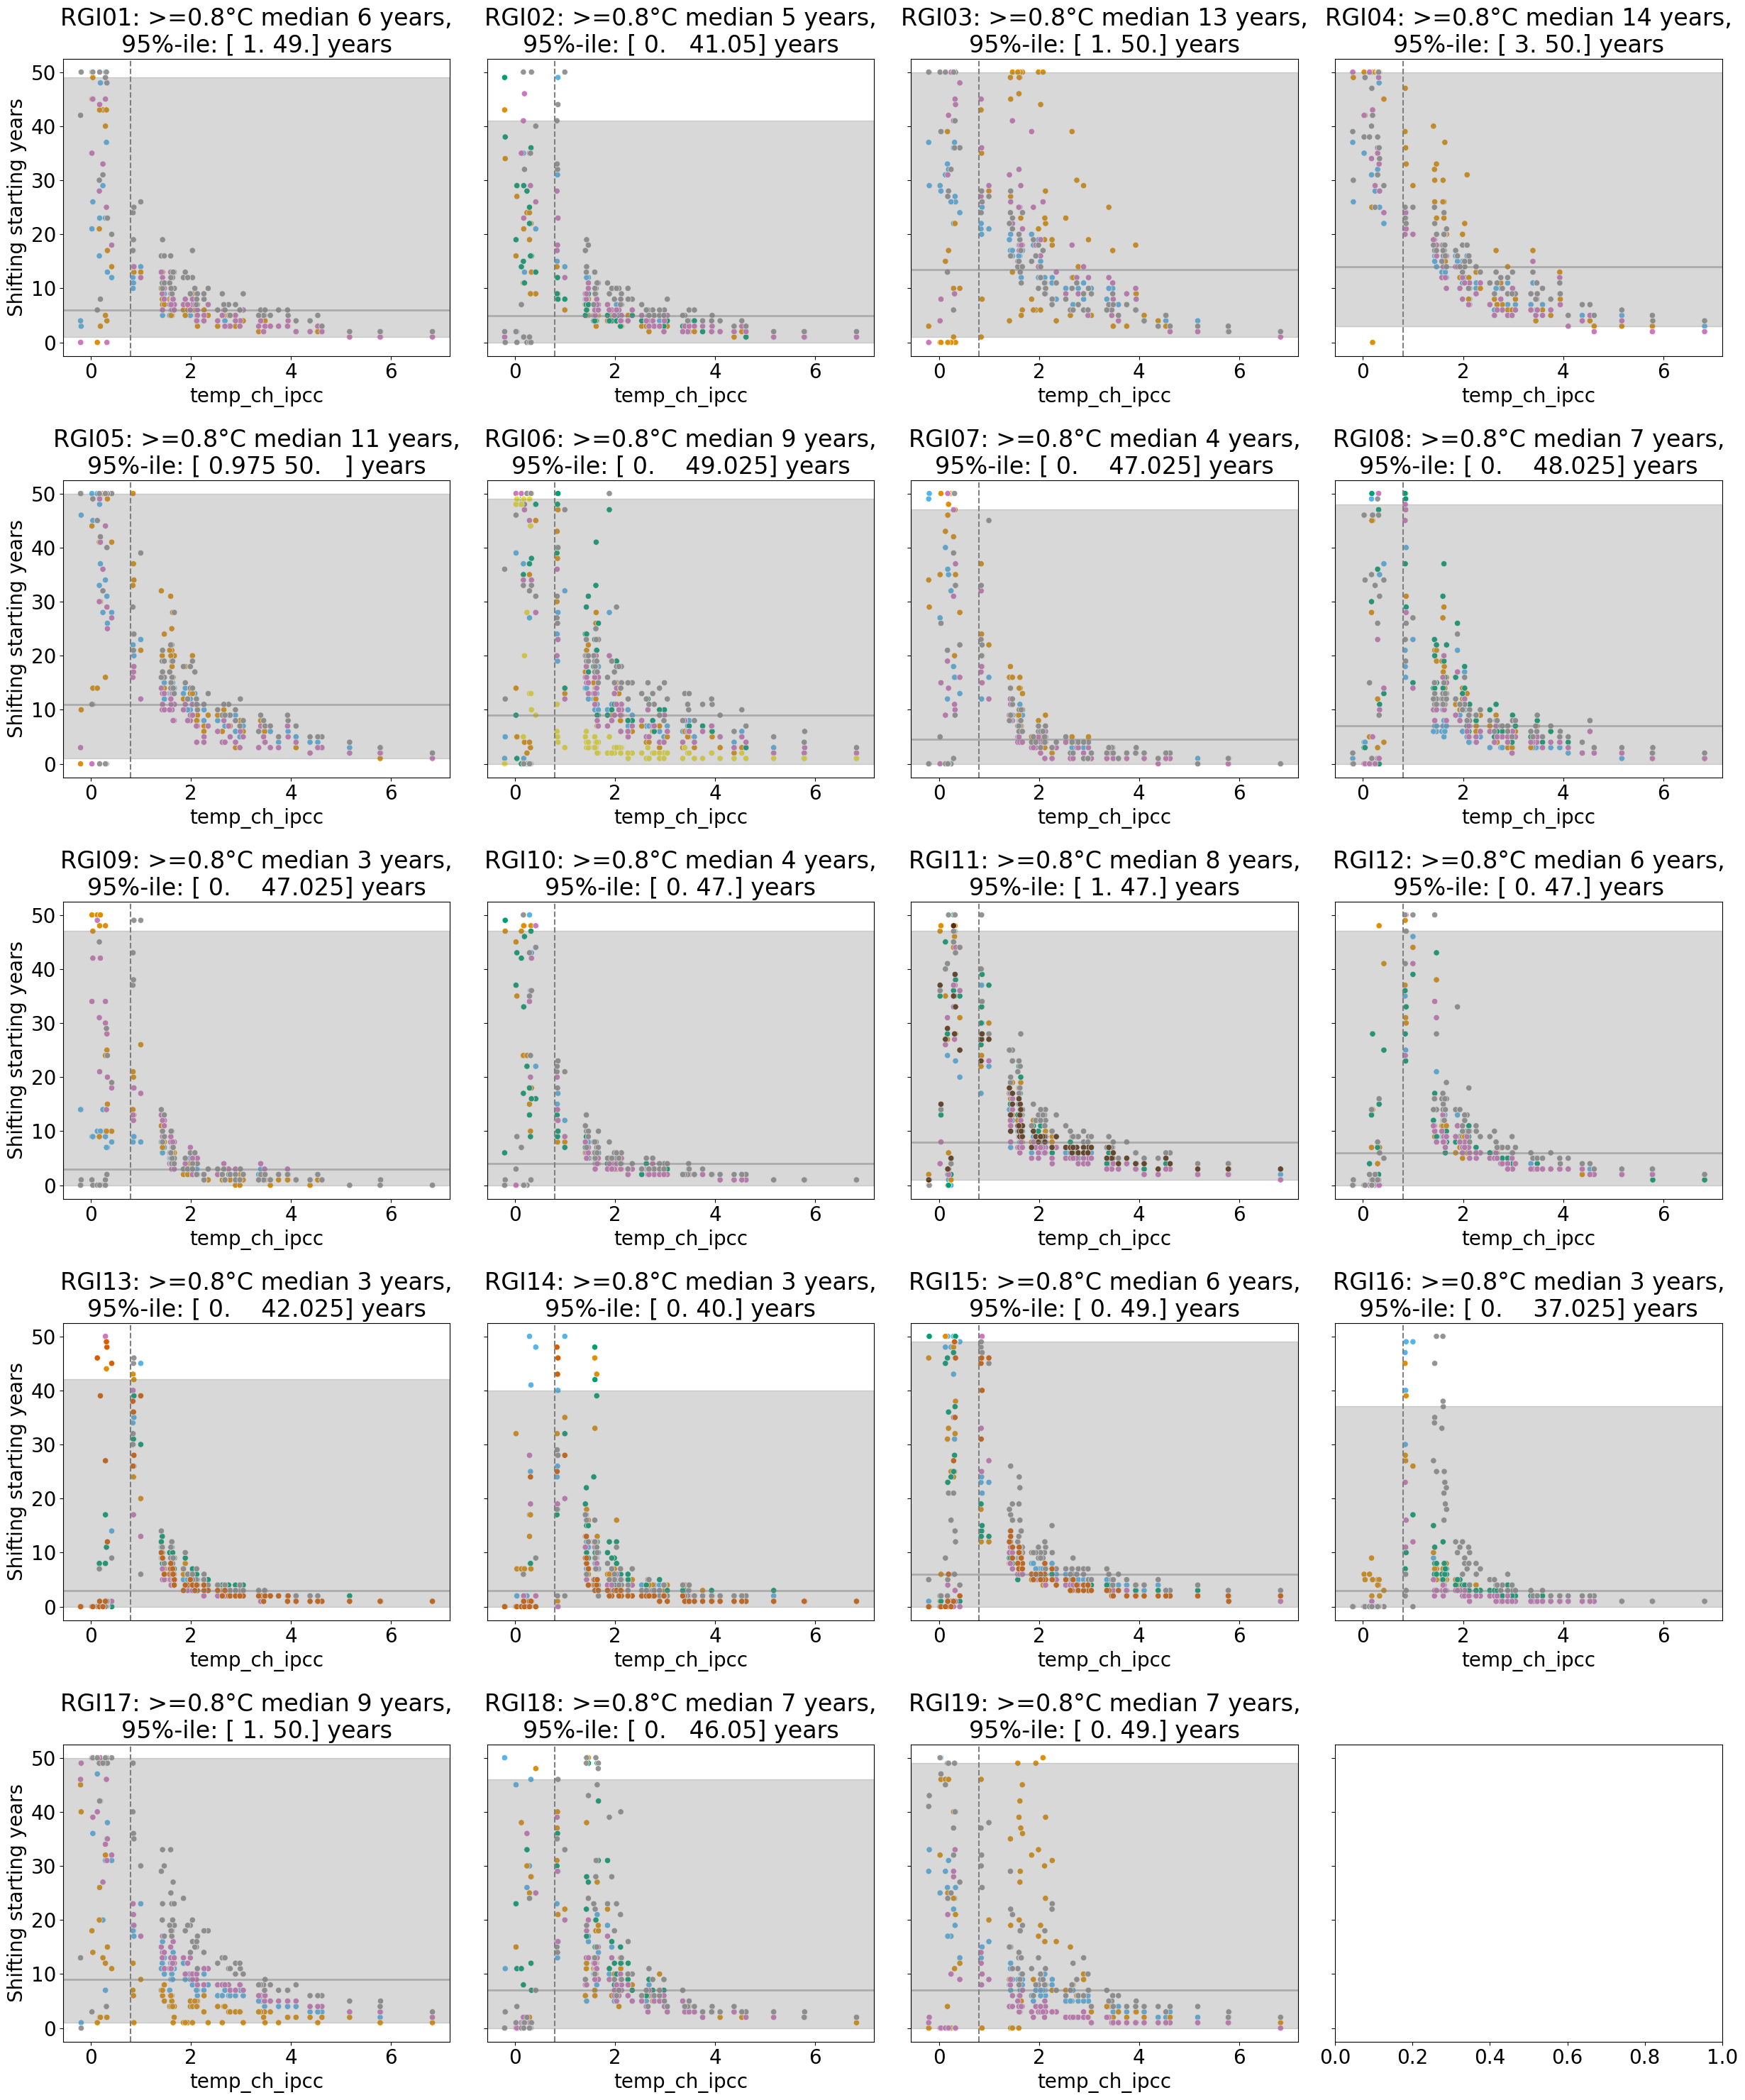

In [20]:
fig, axs = plt.subplots(5,4,figsize=(25,30), sharey=True)
axs = axs.flatten()
for j,rgi_reg in enumerate(ds_reg_yr_shift.rgi_reg.values):
    _t = yrs_w_most_similar_state.sel(rgi_reg=rgi_reg)
    ax = axs[j]
    sns.scatterplot(data=yrs_w_most_similar_state.sel(rgi_reg=rgi_reg).to_dataframe().reset_index().dropna(),
                x='temp_ch_ipcc',
                y='simulation_year',
                hue='model_author',hue_order=dict_model_col.keys(), 
                    palette=dict_model_col.values(),
                    ax = ax,
                    legend=False)
    _tt = _t.where(ds_reg_yr_shift.sel(year_after_2020=0).sel(rgi_reg=rgi_reg).temp_ch_ipcc>=0.8)
    ax.axvline(0.8, color='grey',ls='--')

    ax.axhspan(_tt.quantile(0.025), _tt.quantile(0.975), color='grey', alpha = 0.3)
    ax.axhline(_tt.quantile(0.5), color='grey',alpha = 0.5, lw=2)
    ax.set_title(f'RGI{rgi_reg}: >=0.8°C median {int(_t.quantile(0.5).values)} years,\n95%-ile: {_tt.quantile([0.025, 0.975]).values} years')
    ax.set_ylabel('Shifting starting years')
plt.tight_layout()
plt.savefig(f'figures/0c_shift/0c_shift_new_starting_years_{DATE}.png')

## Create some regional timeseries plots 

In [21]:
dict_model_col = {}
for c,m in zip(pal_models, hue_order):
    dict_model_col[m] = c
#pd_global_temp_exp_glac = pd.read_csv('../data/temp_ch_ipcc_isimip3b_glacier_regionally.csv', index_col = 0)

ls = 'solid'
#just those roughly above 0.8
sel_periods = _glob_vol_test.sel(period_scenario=pd_global_temp_exp.loc[pd_global_temp_exp.temp_ch_ipcc>=0.8].period_scenario.unique())
#ds_reg_yr_shift.period_scenario.values #['1851-1870_hist','1995-2014_hist','2081-2100_ssp126','2081-2100_ssp585']
#for j,period_scenario in enumerate(ds_reg_models.period_scenario.values):
plt.rc('font', size=20)  
j == 0
for anonym in ['_anonym']: #'', 
    for gcm in ds_reg_yr_shift.gcm.values:
        #for rgi_reg in ['11']:
        for rgi_reg in ds_reg_yr_shift.rgi_reg.values:
            vol_2020_reg = pd_rgi_stats_w_hugonnet.loc[rgi_reg][f'regional_volume_m3_2020{approach}']
            def vol_rel_2020_to_vol_km3(x, _vol_2020_reg = vol_2020_reg):
                return x*_vol_2020_reg/1e9/100
            def vol_km3_to_vol_rel_2020(x, _vol_2020_reg = vol_2020_reg):
                return x*1e9*100/_vol_2020_reg
            np.testing.assert_allclose(vol_km3_to_vol_rel_2020(vol_rel_2020_to_vol_km3(100)), 100, rtol=1e-4)
            plt.figure(figsize=(32,30))
            axs = []
            #for j,period_scenario in enumerate(sel_periods):
            for j,period_scenario in enumerate(ds_reg_models.period_scenario.values):
            
                condi3 = (pd_global_temp_exp.period_scenario==period_scenario)
                temp_ch = pd_global_temp_exp.loc[(pd_global_temp_exp.gcm==gcm)& condi3]['temp_ch_ipcc'].round(1).values.squeeze()

                if j==0 or j==2:
                    ax0=plt.subplot(5,4,j+1)
                    ax = ax0
                else:
                    ax=plt.subplot(5,4,j+1,sharey=ax0)
                axs.append(ax)
                
                pd_reg_vol_sel = ds_reg_yr_shift.sel(period_scenario=period_scenario).sel(gcm=gcm).sel(rgi_reg=rgi_reg)['volume_rel_2020_%'].to_dataframe().reset_index()
                pd_reg_vol_sel['volume (km³)'] = pd_reg_vol_sel['volume_rel_2020_%']*vol_2020_reg/1e9/100
                pd_reg_vol_sel = pd_reg_vol_sel.dropna()
                
                models_reg = pd_reg_vol_sel.model_author.unique()
                dict_model_col_reg = {}
                list_reg_model_anonym = []
                for h, p in zip(hue_order,pal_models):
                    if h in models_reg:
                        dict_model_col_reg[h]= p
                        list_reg_model_anonym.append(model_order_anonymous[h])
                if ls == 'solid' and j==0:
                    sns.lineplot(x='year_after_2020', data=pd_reg_vol_sel, y='volume (km³)',
                             hue='model_author', hue_order=dict_model_col.keys(), palette=dict_model_col.values(), ls=ls,
                                 legend='brief', lw=3, ax=ax)
                else:
                    sns.lineplot(x='year_after_2020', data=pd_reg_vol_sel, y='volume (km³)',
                             hue='model_author', hue_order=dict_model_col.keys(), palette=dict_model_col.values(), ls=ls,
                                 legend=False, lw=3, ax=ax)
                ax.axvline(0,color='grey', ls='--',lw=2)
                ax2 = ax.secondary_yaxis(1., functions=(vol_km3_to_vol_rel_2020, 
                                                        vol_rel_2020_to_vol_km3)) #perc_to_slr_lin))
                # add runaway effect
                #pd_reg_vol_sel_runaway_oggm = ds_reg_models_w_runaway.sel(period_scenario=period_scenario).sel(gcm=gcm).volume_m3.to_dataframe().reset_index()
                #pd_reg_vol_sel_runaway_oggm['volume (km³)'] = pd_reg_vol_sel_runaway_oggm['volume_m3']/1e9

                #sns.lineplot(x='simulation_year', data=pd_reg_vol_sel_runaway_oggm.loc[pd_reg_vol_sel_runaway_oggm.rgi_reg==rgi_reg], y='volume (km³)',
                #             color=dict_model_col['OGGM_v16'], ls='--', legend=False, lw=0.5, #ax=ax,
                #             alpha =1)

                if j in [0,4,8,12,16]:
                    plt.ylabel('Volume (km³)', fontsize=22)
                else:
                    plt.ylabel('')
                plt.xlabel('Year after 2020', fontsize=22)

                #for m in dict_model_col.keys():
                #    yr = yrs_w_most_similar_state.sel(period_scenario=period_scenario).sel(gcm=gcm).sel(model_author=m)
                #    print(rgi_reg, period_scenario, m, yr.values)
                #    plt.axvline(yr, ls='--', color=dict_model_col[m])
                #ax.axhline(vol_2020_reg/1e9, color='black', ls=':')

                if j==0: 
                    _leg = ax.get_legend()
                    handles, labels = ax.get_legend_handles_labels()
                    _leg.remove()
                    n = len(models_reg)
                    if anonym:
                        leg = ax.legend(handles, list_reg_model_anonym, title=f'{n} models', loc='upper right', framealpha = 0.7, ncol=2,
                                        bbox_to_anchor=(0.99,0.92))
                    else:
                        leg = ax.legend(handles, dict_model_col_reg.keys(), title=f'{n} models', loc='upper right', framealpha = 0.7)
                    for legobj in leg.legendHandles:
                        legobj.set_linewidth(3.0)
                    leg.set_zorder = 5

                #leg.set_bbox_to_anchor([1,1])
                ax.text(0.02,0.94, str(period_scenario) +r': ($\Delta$T$_{global}$'+f'={temp_ch}°C)', color='grey', 
                        fontsize=22, transform=ax.transAxes, zorder=6)

                if j in [3,7,11,15]:
                    ax2.set_ylabel('Volume (rel. to 2020, in %)', fontsize=22)
                else:
                    ax2.set_ylabel('')
                ax.set_xlim([-50,500])
                ax2.set_xlim([-50,500])
            reg = d_reg_num_name[rgi_reg]
            plt.suptitle(f'RGI region: {rgi_reg} ({reg}) - {gcm.upper()}', fontsize=30)
            plt.tight_layout()
            
            plt.savefig(f'figures/0c_shift/gcm_separate_vol_time_series/shifted_vol_time_series_rgi_reg{rgi_reg}_{gcm}{anonym}_{DATE}.png')
            plt.close()

**Plots to explain the selection procedure**

11 1851-1870_hist PyGEM-OGGM_v13 27.0
11 1851-1870_hist GloGEMflow 35.0
11 1851-1870_hist GloGEMflow3D 45.0
11 1851-1870_hist OGGM_v16 26.0
11 1851-1870_hist GLIMB 40.0
11 1851-1870_hist Kraaijenbrink nan
11 1851-1870_hist GO nan
11 1851-1870_hist CISM2 27.0
11 1995-2014_hist PyGEM-OGGM_v13 30.0
11 1995-2014_hist GloGEMflow 33.0
11 1995-2014_hist GloGEMflow3D 39.0
11 1995-2014_hist OGGM_v16 27.0
11 1995-2014_hist GLIMB 34.0
11 1995-2014_hist Kraaijenbrink nan
11 1995-2014_hist GO nan
11 1995-2014_hist CISM2 28.0
11 2081-2100_ssp126 PyGEM-OGGM_v13 9.0
11 2081-2100_ssp126 GloGEMflow 12.0
11 2081-2100_ssp126 GloGEMflow3D 11.0
11 2081-2100_ssp126 OGGM_v16 8.0
11 2081-2100_ssp126 GLIMB 15.0
11 2081-2100_ssp126 Kraaijenbrink nan
11 2081-2100_ssp126 GO nan
11 2081-2100_ssp126 CISM2 10.0
11 2081-2100_ssp585 PyGEM-OGGM_v13 3.0
11 2081-2100_ssp585 GloGEMflow 3.0
11 2081-2100_ssp585 GloGEMflow3D 4.0
11 2081-2100_ssp585 OGGM_v16 3.0
11 2081-2100_ssp585 GLIMB 6.0
11 2081-2100_ssp585 Kraaijenbrink n

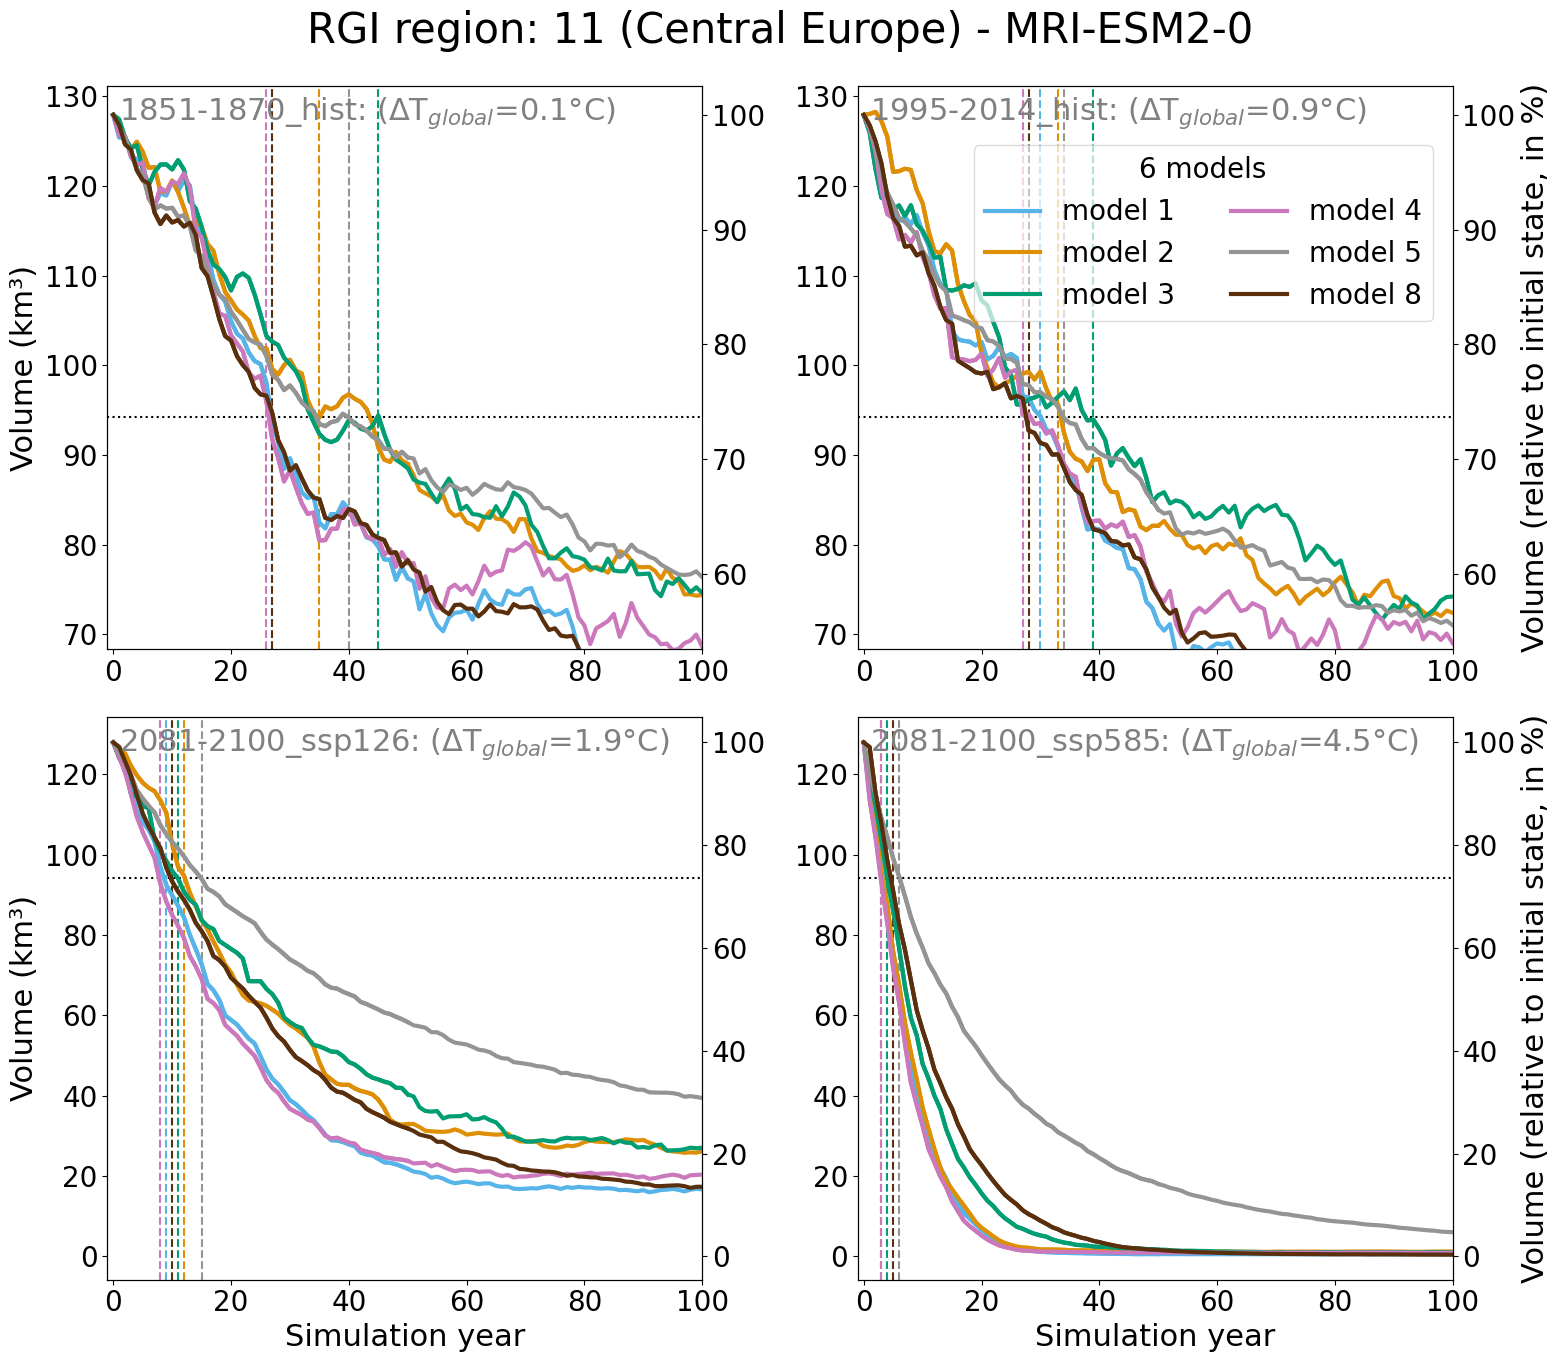

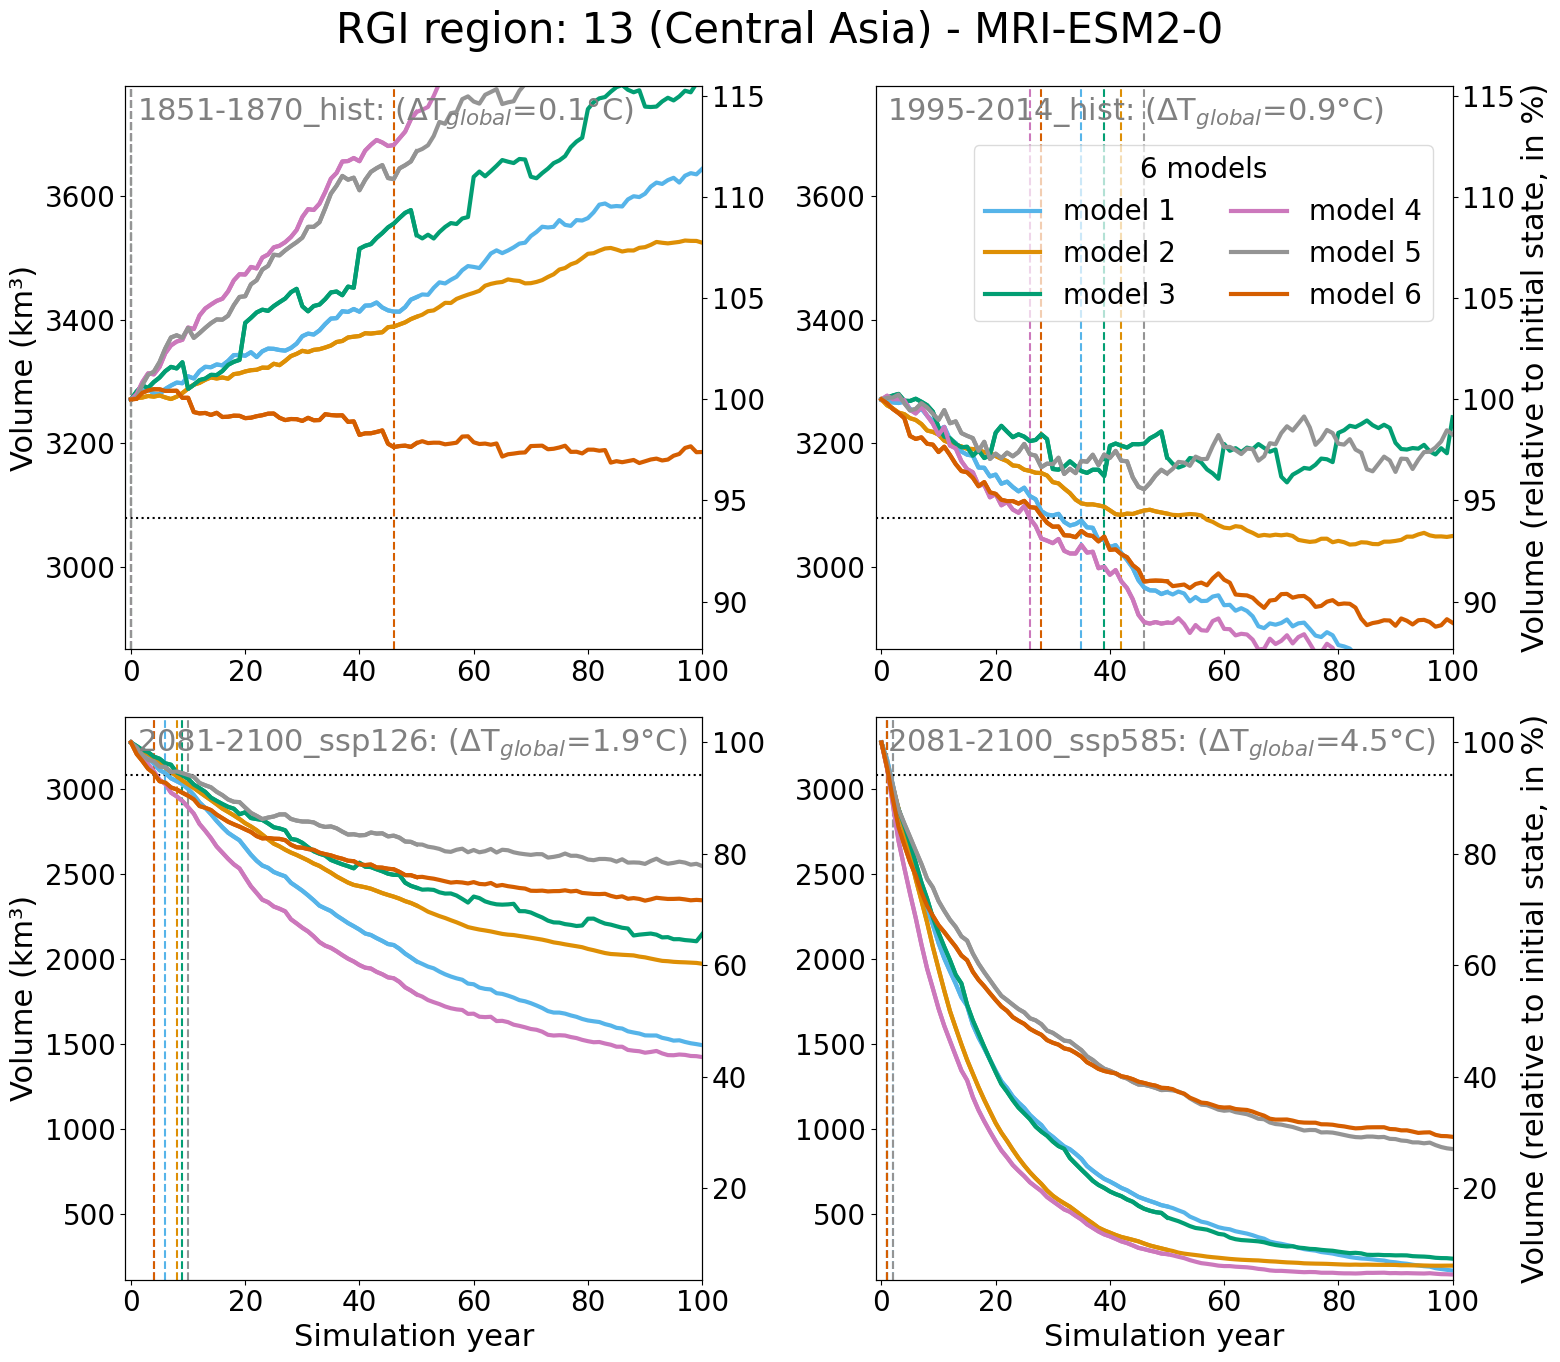

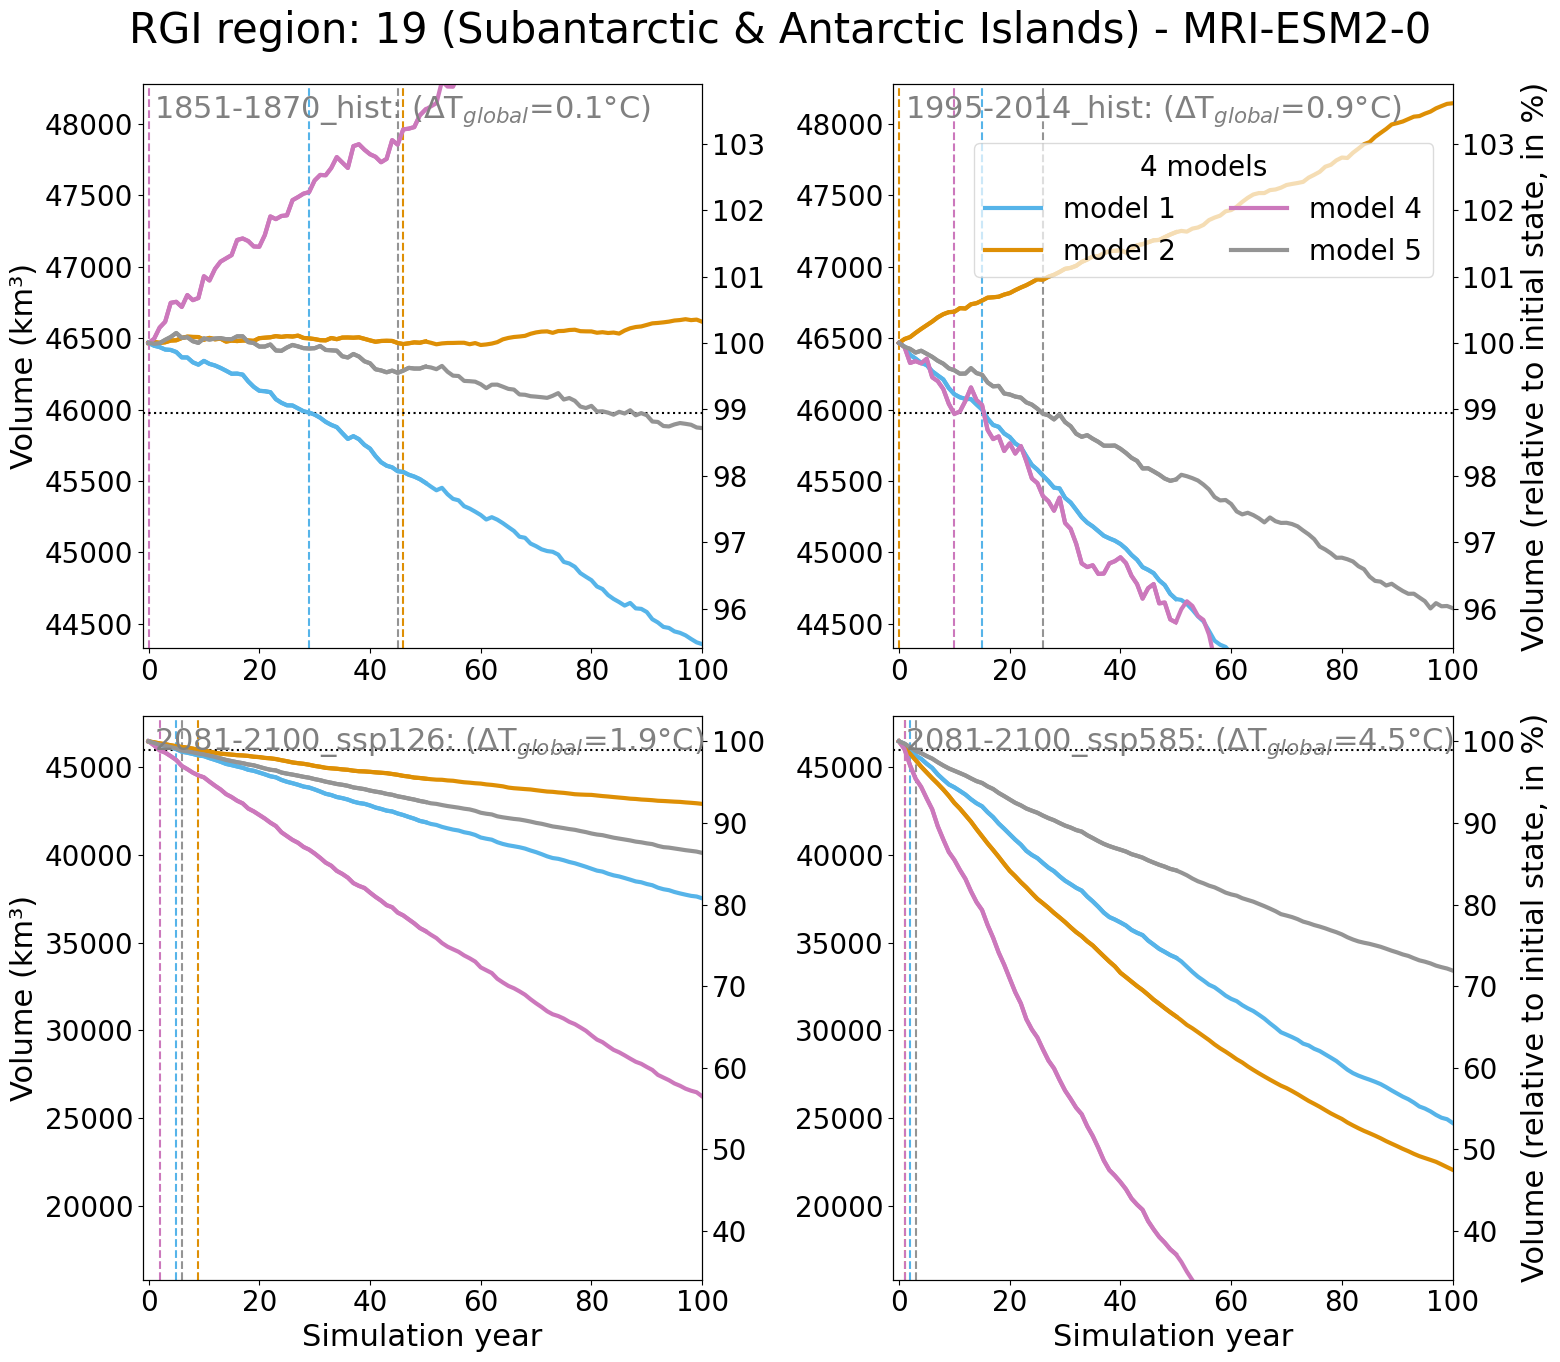

In [22]:
dict_model_col = {}
for c,m in zip(pal_models, hue_order):
    dict_model_col[m] = c
#pd_global_temp_exp_glac = pd.read_csv('../data/temp_ch_ipcc_isimip3b_glacier_regionally.csv', index_col = 0)

ls = 'solid'
sel_periods = ['1851-1870_hist','1995-2014_hist','2081-2100_ssp126','2081-2100_ssp585']
#for j,period_scenario in enumerate(ds_reg_models.period_scenario.values):

for anonym in ['_anonym']: #'', 
    for gcm in ['mri-esm2-0']:
        #for rgi_reg in ['11']:
        for rgi_reg in ['11','13','19']:
            vol_2020_reg = pd_rgi_stats_w_hugonnet.loc[rgi_reg][f'regional_volume_m3_2020{approach}']
            ds_reg_models_vol_rel_2020 = 100*ds_reg_models_vol.sel(simulation_year=slice(0,50)).sel(rgi_reg=rgi_reg)/vol_2020_reg
            yrs_w_most_similar_state = np.abs(ds_reg_models_vol_rel_2020-100).idxmin(dim='simulation_year')
            
            plt.figure(figsize=(16,14))
            axs = []
            for j,period_scenario in enumerate(sel_periods):
                condi3 = (pd_global_temp_exp.period_scenario==period_scenario)
                temp_ch = pd_global_temp_exp.loc[(pd_global_temp_exp.gcm==gcm)& condi3]['temp_ch_ipcc'].round(1).values.squeeze()

                if j==0 or j==2:
                    ax0=plt.subplot(2,2,j+1)
                    ax = ax0
                else:
                    ax=plt.subplot(2,2,j+1,sharey=ax0)
                axs.append(ax)
                
                pd_reg_vol_sel = ds_reg_models.sel(simulation_year=slice(0,50)).sel(period_scenario=period_scenario).sel(gcm=gcm).sel(rgi_reg=rgi_reg).volume_m3.to_dataframe().reset_index()
                pd_reg_vol_sel['volume (km³)'] = pd_reg_vol_sel['volume_m3']/1e9
                pd_reg_vol_sel = pd_reg_vol_sel.dropna()
                
                if ls == 'solid' and j==3:
                    sns.lineplot(x='simulation_year', data=pd_reg_vol_sel, y='volume (km³)',
                             hue='model_author', hue_order=dict_model_col.keys(), palette=dict_model_col.values(), ls=ls, legend=False, lw=3, ax=ax)
                else:
                    sns.lineplot(x='simulation_year', data=pd_reg_vol_sel, y='volume (km³)',
                             hue='model_author', hue_order=dict_model_col.keys(), palette=dict_model_col.values(), ls=ls, legend=False, lw=3, ax=ax)

                # add runaway effect
                #pd_reg_vol_sel_runaway_oggm = ds_reg_models_w_runaway.sel(period_scenario=period_scenario).sel(gcm=gcm).volume_m3.to_dataframe().reset_index()
                #pd_reg_vol_sel_runaway_oggm['volume (km³)'] = pd_reg_vol_sel_runaway_oggm['volume_m3']/1e9

                #sns.lineplot(x='simulation_year', data=pd_reg_vol_sel_runaway_oggm.loc[pd_reg_vol_sel_runaway_oggm.rgi_reg==rgi_reg], y='volume (km³)',
                #             color=dict_model_col['OGGM_v16'], ls='--', legend=False, lw=0.5, #ax=ax,
                #             alpha =1)

                if j in [0,2]:
                    plt.ylabel('Volume (km³)', fontsize=22)
                else:
                    plt.ylabel('')
                plt.xlabel('Simulation year', fontsize=22)

                ax.set_xlim([-1,100])
                if j==1:
                    minip, maxip = ax.get_ylim()
                elif j==3:
                    minif, maxif = ax.get_ylim()

                for m in dict_model_col.keys():
                    yr = yrs_w_most_similar_state.sel(period_scenario=period_scenario).sel(gcm=gcm).sel(model_author=m)
                    print(rgi_reg, period_scenario, m, yr.values)
                    plt.axvline(yr, ls='--', color=dict_model_col[m])
                ax.axhline(vol_2020_reg/1e9, color='black', ls=':')


            for j,period_scenario in enumerate(sel_periods):
                condi3 = (pd_global_temp_exp.period_scenario==period_scenario)
                temp_ch = pd_global_temp_exp.loc[(pd_global_temp_exp.gcm==gcm)& condi3]['temp_ch_ipcc'].round(1).values.squeeze()
                
                ax = axs[j]
                ax2 = ax.twinx()
                
                sel_ds_reg_model_vol = ds_reg_models.sel(simulation_year=slice(0,100)).sel(period_scenario=period_scenario).sel(gcm=gcm).sel(rgi_reg=rgi_reg).volume_m3
                _ref = 100*sel_ds_reg_model_vol/sel_ds_reg_model_vol.sel(simulation_year=0)
                pd_reg_vol_sel = _ref.to_dataframe().reset_index()
                pd_reg_vol_sel['volume (relative to initial state, in %)'] = pd_reg_vol_sel['volume_m3']
                pd_reg_vol_sel = pd_reg_vol_sel.dropna()
                # get  regional models and correct color, anonym model number 
                # to  get a legend with only the models of that region... 
                models_reg = pd_reg_vol_sel.model_author.unique()
                dict_model_col_reg = {}
                list_reg_model_anonym = []
                for h, p in zip(hue_order,pal_models):
                    if h in models_reg:
                        dict_model_col_reg[h]= p
                        list_reg_model_anonym.append(model_order_anonymous[h])
                if ls == 'solid' and j==1:
                    sns.lineplot(x='simulation_year', data=pd_reg_vol_sel,
                                 y='volume (relative to initial state, in %)',
                                 hue='model_author', hue_order=dict_model_col_reg.keys(), palette=dict_model_col_reg.values(), ls=ls, legend='brief', lw=3, ax=ax2)
                else:
                    sns.lineplot(x='simulation_year', data=pd_reg_vol_sel,
                                 y='volume (relative to initial state, in %)',
                                 hue='model_author', hue_order=dict_model_col_reg.keys(), palette=dict_model_col_reg.values(), ls=ls, legend=False, lw=3, ax=ax2)
            
                if j in [1,3]:
                    ax2.set_ylabel('Volume (relative to initial state, in %)', fontsize=22)
                    #ax.set_yticklabels([])
                else:
                    ax2.set_ylabel('')
                    #ax2.set_yticklabels([])

                if j==1: 
                    _leg = ax2.get_legend()
                    handles, labels = ax2.get_legend_handles_labels()
                    _leg.remove()
                    n = len(models_reg)
                    if anonym:
                        leg = ax2.legend(handles, list_reg_model_anonym, title=f'{n} models', loc='upper right', framealpha = 0.7, ncol=2,
                                        bbox_to_anchor=(0.99,0.92))
                    else:
                        leg = ax2.legend(handles, dict_model_col_reg.keys(), title=f'{n} models', loc='upper right', framealpha = 0.7)
                    for legobj in leg.legendHandles:
                        legobj.set_linewidth(3.0)
                    leg.set_zorder = 5

                #leg.set_bbox_to_anchor([1,1])
                ax2.text(0.02,0.94, str(period_scenario) +r': ($\Delta$T$_{global}$'+f'={temp_ch}°C)', color='grey', 
                        fontsize=22, transform=ax2.transAxes, zorder=6)
                    

                rel = 100*1e9/sel_ds_reg_model_vol.sel(simulation_year=0)
                rel = rel.dropna(dim='model_author')
                np.testing.assert_allclose(rel[0], rel)
                rel = rel[0].values

                if j<2:
                    ax2.set_ylim([minip*rel,maxip*rel])
                    ax.set_xlabel('')
                else:
                    ax2.set_ylim([minif*rel,maxif*rel])
                    


            reg = d_reg_num_name[rgi_reg]
            plt.suptitle(f'RGI region: {rgi_reg} ({reg}) - {gcm.upper()}', fontsize=30)
            plt.tight_layout()

            plt.savefig(f'figures/0c_shift/gcm_separate_vol_time_series/sel_manuscript_vol_time_series_rgi_reg{rgi_reg}_{gcm}{anonym}_{DATE}.png')
    

**Tests to check maximum simulation year sensitivity**

In [23]:
max_year_shift = 200
ds_reg_models_vol_rel_2020 = 100*ds_reg_models_vol_stack/pd_rgi_stats_w_hugonnet.loc[ds_reg_models_vol_stack.rgi_reg][f'regional_volume_m3_2020{approach}'].values.reshape(1,19,1,1)
# allow a maximum shift of 200 years
yrs_w_most_similar_state = np.abs(ds_reg_models_vol_rel_2020.sel(simulation_year=slice(0,max_year_shift))-100).idxmin(dim='simulation_year')

ds_reg_models_vol_rel_2020 = ds_reg_models_vol_rel_2020.assign_coords(yrs_w_most_similar_state_to_2020 = (['model_author','rgi_reg','experiments'],
                                              yrs_w_most_similar_state.data))
new_start_yr = ds_reg_models_vol_rel_2020.simulation_year.data.reshape(1,1,5001,1) - ds_reg_models_vol_rel_2020['yrs_w_most_similar_state_to_2020'].data.reshape(8,19,1,80)
ds_reg_models_vol_rel_2020 = ds_reg_models_vol_rel_2020.assign_coords(year_after_2020 = (['model_author','rgi_reg',
                                                                                                            'simulation_year','experiments'],
                                              new_start_yr))
_ds_t_l = []
for rgi_reg in ds_reg_models_vol_rel_2020.rgi_reg:
    ### it is too slow if we don't do it for every region separately ... 
    _p_test = ds_reg_models_vol_rel_2020.sel(rgi_reg=rgi_reg).to_dataframe().reset_index()
    #_p_test = _p_test.loc[_p_test.new_start_yr>=0]
    _ds_t = _p_test.groupby(['model_author','rgi_reg','year_after_2020','period_scenario','gcm']).mean().to_xarray()
    _ds_t = _ds_t.rename_vars({'volume_m3':'volume_rel_2020_%'})
    _ds_t_l.append(_ds_t)
    #print(rgi_reg.values)
    #_ds_t = _ds_t.sel(year_after_2020=slice(0,4900))
ds_reg_yr_shift_200 = xr.concat(_ds_t_l, dim='rgi_reg')

In [24]:
_convert = pd_rgi_stats_w_hugonnet.loc[ds_reg_models_vol_stack.rgi_reg][f'regional_volume_m3_2020{approach}'].values.reshape(1,19,1,1,1)
ds_reg_yr_shift_200['volume_m3'] = ds_reg_yr_shift_200['volume_rel_2020_%'] * _convert/100
_glob_vol_test = ds_reg_yr_shift_200['volume_m3'].sel(year_after_2020=0).median(dim='model_author').sum(dim='rgi_reg')
# above 08 should match better t
_glob_vol_test_ab_08 = _glob_vol_test.sel(period_scenario=pd_global_temp_exp.loc[pd_global_temp_exp.temp_ch_ipcc>=0.8].period_scenario.unique())
np.testing.assert_allclose(_glob_vol_test_ab_08, pd_rgi_stats_w_hugonnet.loc['Globally', f'regional_volume_m3_2020{approach}'], rtol=5e-3)
np.testing.assert_allclose(_glob_vol_test, pd_rgi_stats_w_hugonnet.loc['Globally', f'regional_volume_m3_2020{approach}'], rtol=5e-2)

In [25]:
# if we use maximum 200 years -> get a bit better match : we might use that one instead ??? 
np.testing.assert_allclose(_glob_vol_test_ab_08, pd_rgi_stats_w_hugonnet.loc['Globally', f'regional_volume_m3_2020{approach}'], rtol=4e-3)
np.testing.assert_allclose(_glob_vol_test, pd_rgi_stats_w_hugonnet.loc['Globally', f'regional_volume_m3_2020{approach}'], rtol=3e-2)

In [26]:
((np.abs(_glob_vol_test_ab_08-pd_rgi_stats_w_hugonnet.loc['Globally',
                                                   f'regional_volume_m3_2020{approach}']))/pd_rgi_stats_w_hugonnet.loc['Globally',
                                                                                                            f'regional_volume_m3_2020{approach}']).max()

<xarray.DataArray 'volume_m3' ()>
array(0.0033168)
Coordinates:
    year_after_2020  float64 0.0

In [27]:
((np.abs(_glob_vol_test-pd_rgi_stats_w_hugonnet.loc['Globally',
                                                   f'regional_volume_m3_2020{approach}']))/pd_rgi_stats_w_hugonnet.loc['Globally',
                                                                                                            f'regional_volume_m3_2020{approach}']).max()

<xarray.DataArray 'volume_m3' ()>
array(0.02175616)
Coordinates:
    year_after_2020  float64 0.0

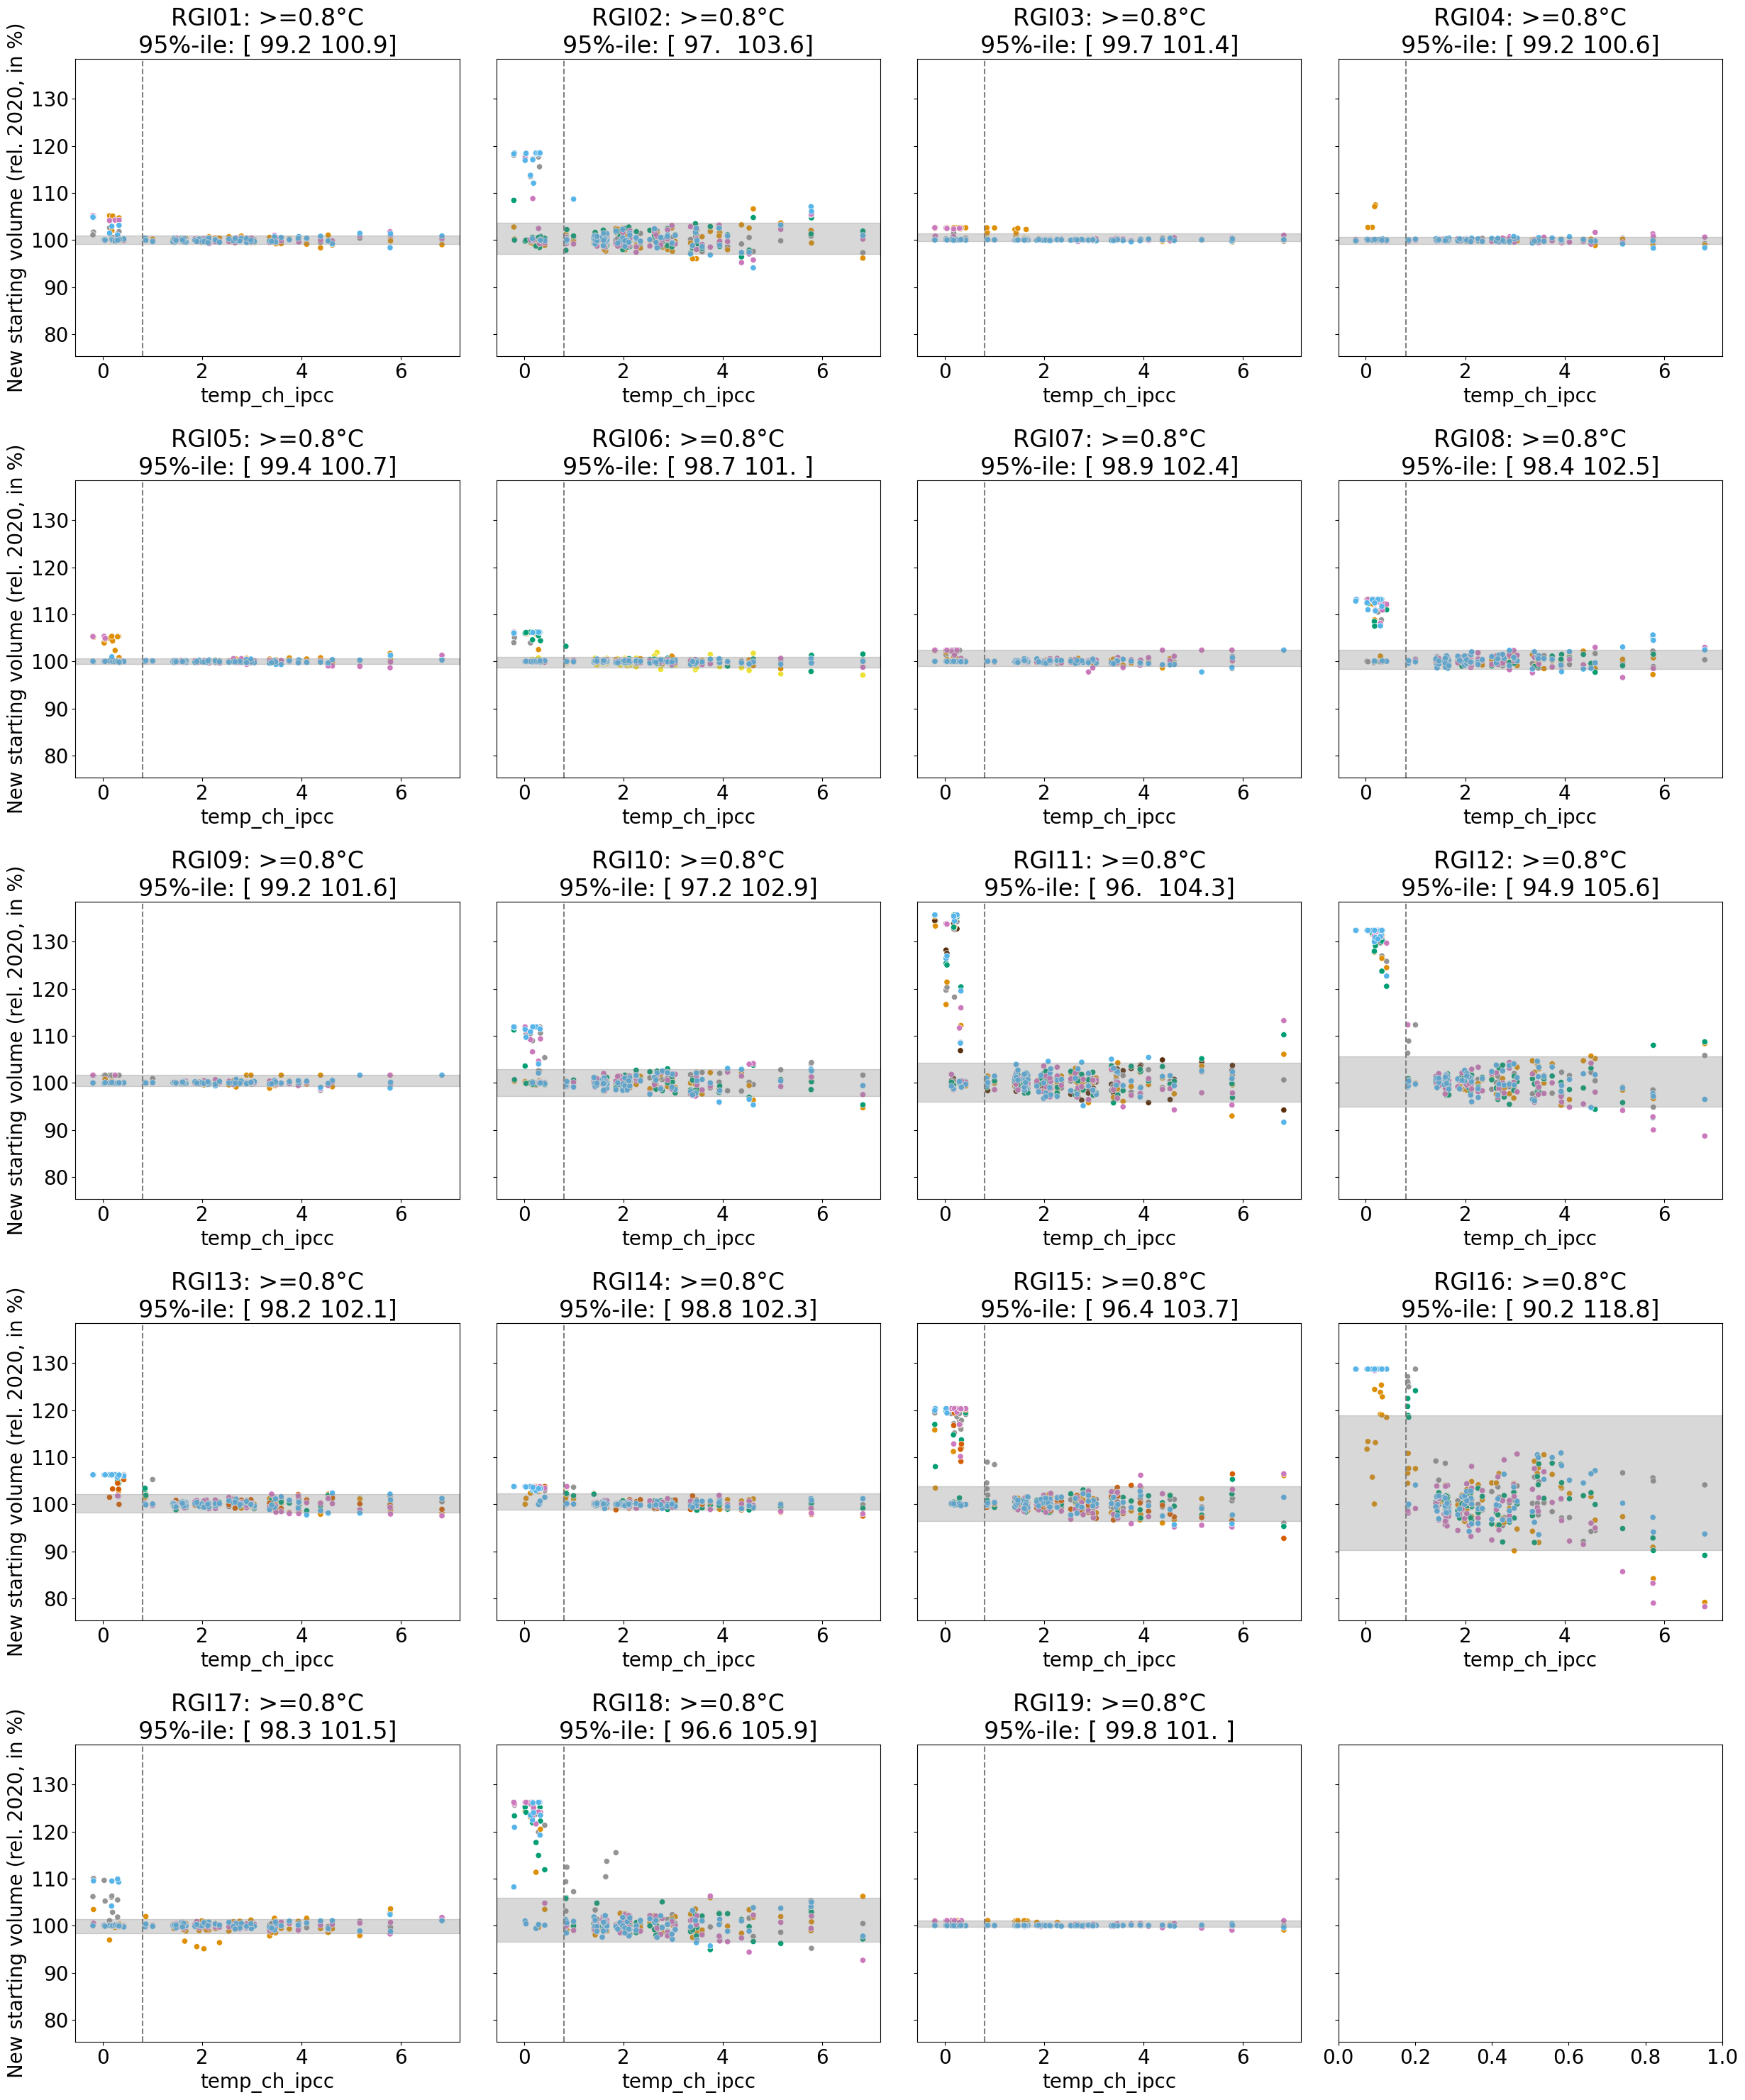

In [28]:
plt.rc('font', size=20)  

fig, axs = plt.subplots(5,4,figsize=(25,30), sharey=True)
axs = axs.flatten()

for j,rgi_reg in enumerate(ds_reg_yr_shift_200.rgi_reg.values):
    _t = ds_reg_yr_shift_200.sel(year_after_2020=0).sel(rgi_reg=rgi_reg)['volume_rel_2020_%']
    #print(rgi_reg, _t.quantile([0,0.01,0.02,0.98,0.99,1]).values)
    ax = axs[j]
    sns.scatterplot(data=ds_reg_yr_shift_200.sel(year_after_2020=0).sel(rgi_reg=rgi_reg).to_dataframe().reset_index().dropna(),
                x='temp_ch_ipcc',
                y='volume_rel_2020_%',
                hue='model_author',hue_order=dict_model_col.keys(), 
                    palette=dict_model_col.values(),
                    ax = ax,
                    legend=False)
    ax.axvline(0.8, color='grey',ls='--')
    #_tt = _t.where(_t.temp_ch_ipcc>=0.8)
    _tt = _t.where(ds_reg_yr_shift_200.sel(year_after_2020=0).sel(rgi_reg=rgi_reg).temp_ch_ipcc>=0.8)
    ax.axhspan(_tt.quantile(0.025), _tt.quantile(0.975), color='grey', alpha = 0.3)
    ax.set_title(f'RGI{rgi_reg}: >=0.8°C\n95%-ile: {_tt.quantile([0.025, 0.975]).values.round(1)}')
    ax.set_ylabel('New starting volume (rel. 2020, in %)')
plt.tight_layout()


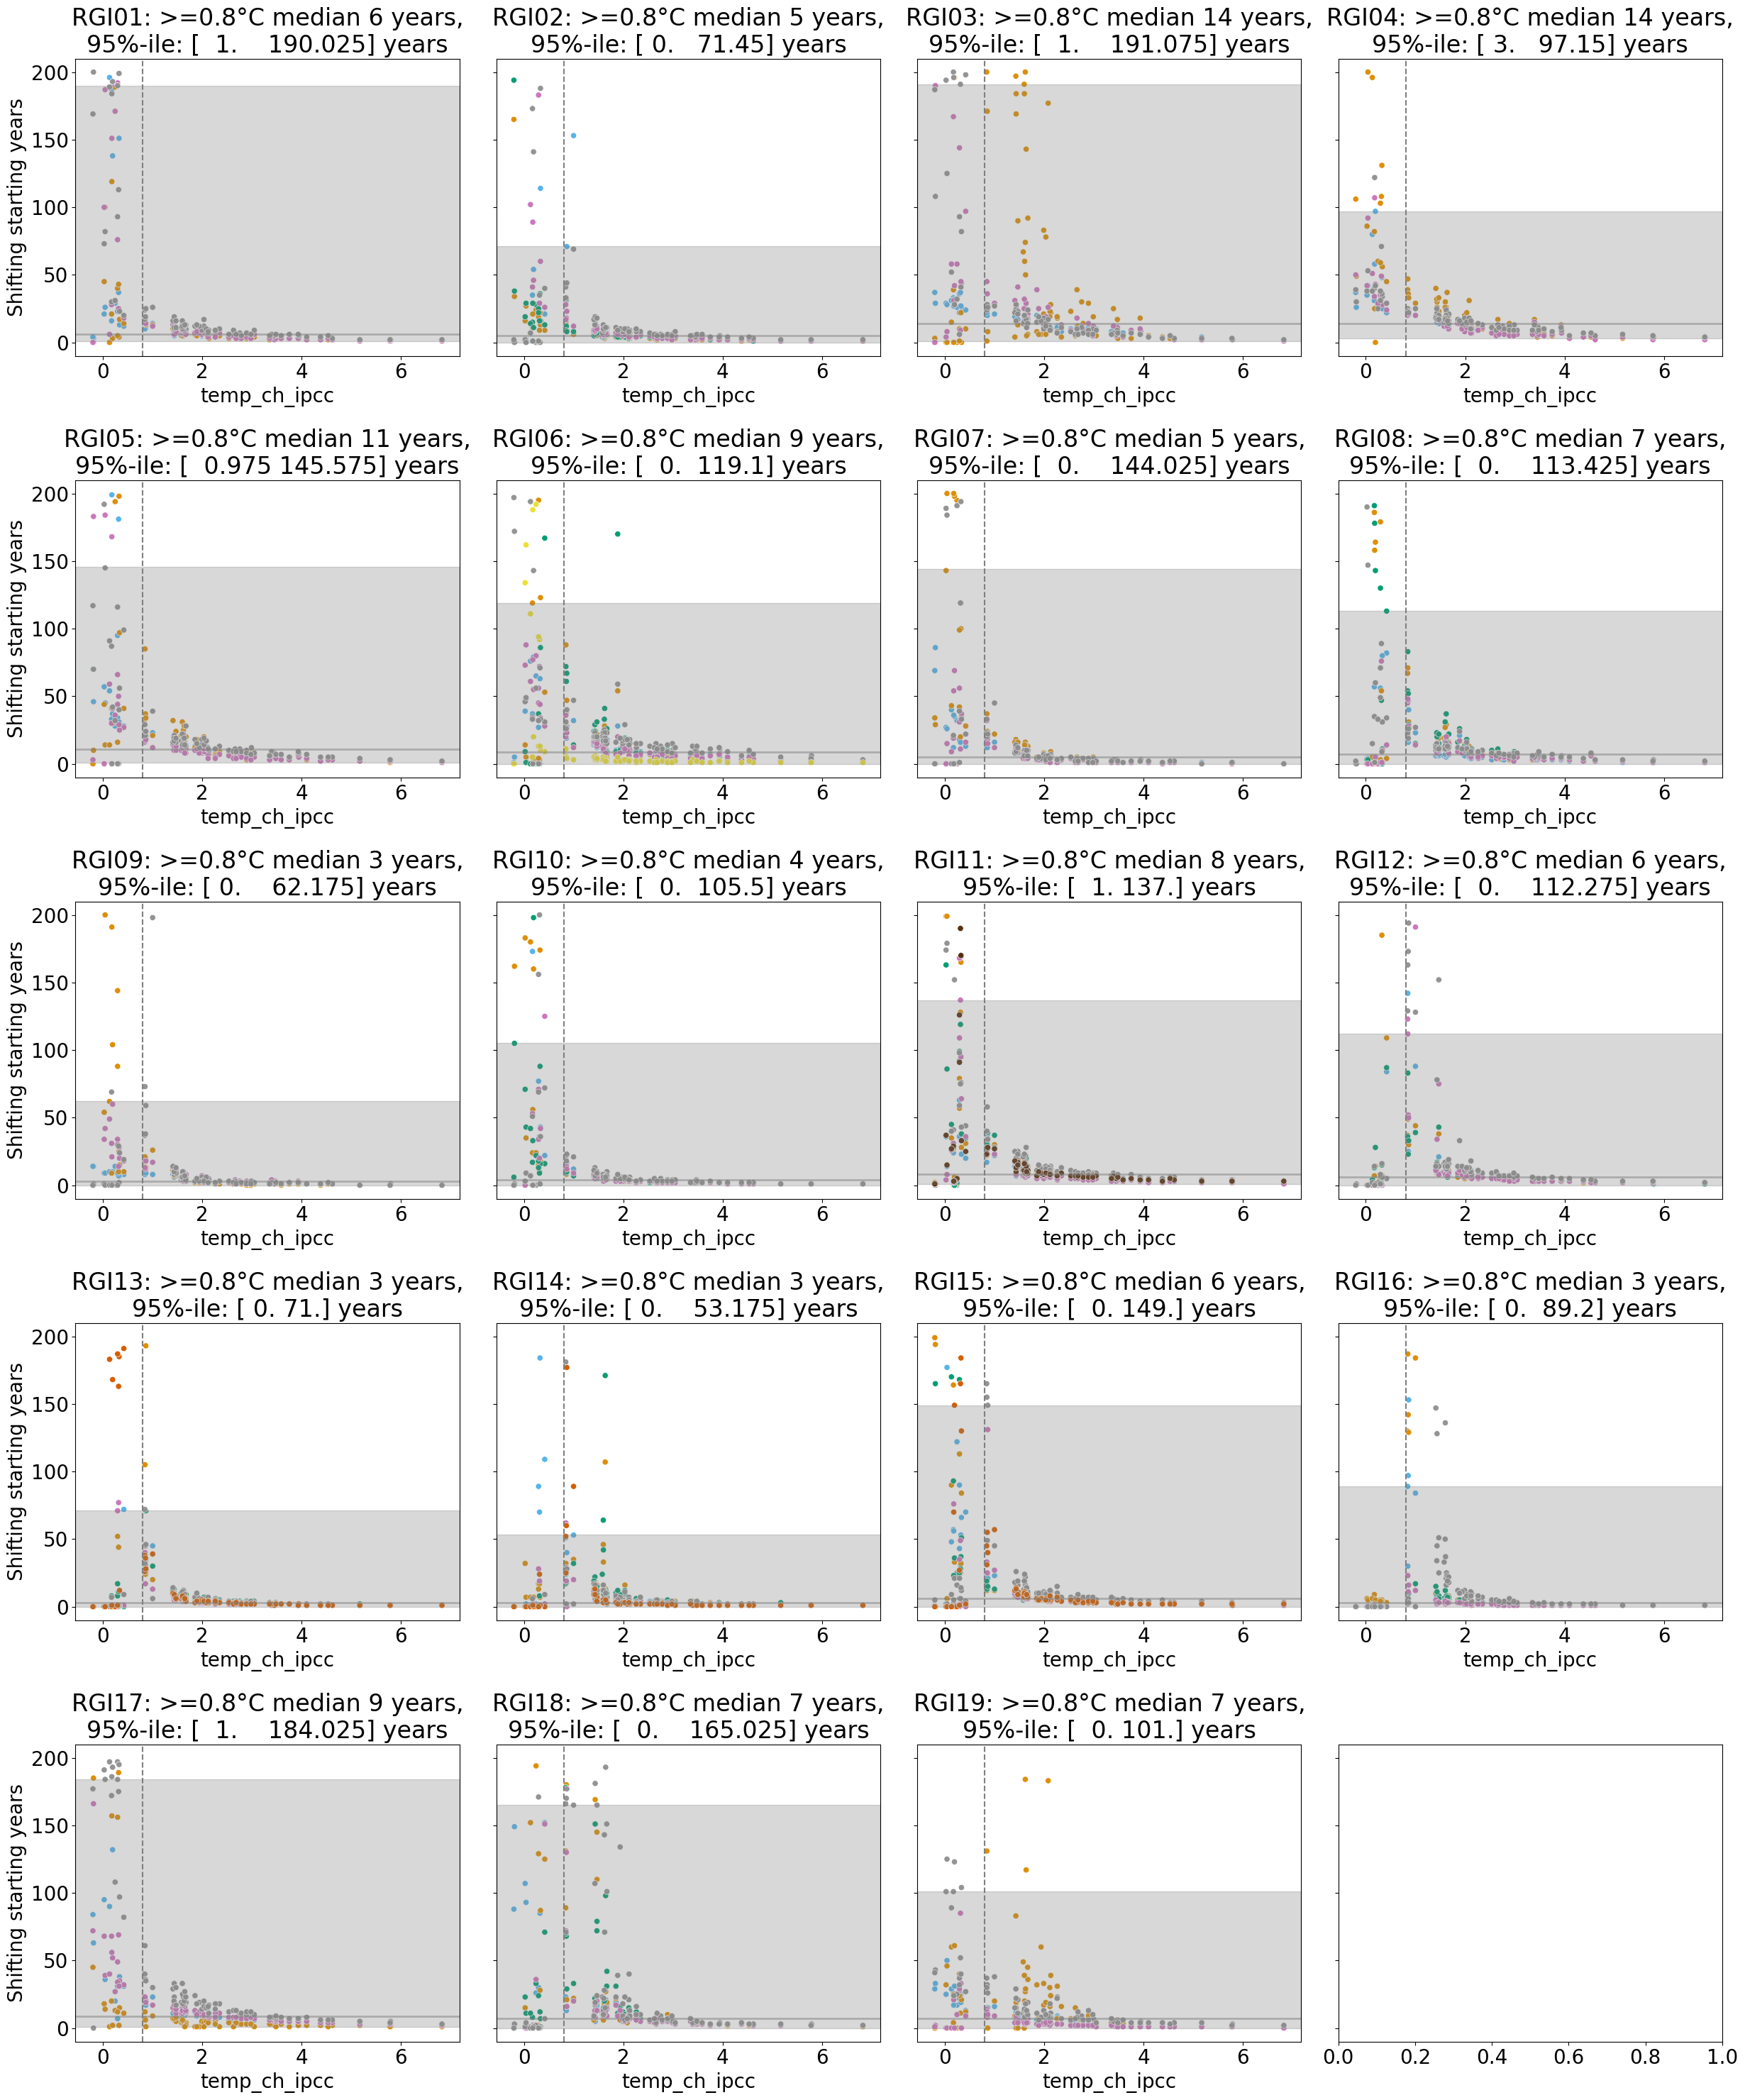

In [29]:
fig, axs = plt.subplots(5,4,figsize=(25,30), sharey=True)
axs = axs.flatten()
for j,rgi_reg in enumerate(ds_reg_yr_shift_200.rgi_reg.values):
    _t = yrs_w_most_similar_state.sel(rgi_reg=rgi_reg)
    ax = axs[j]
    sns.scatterplot(data=yrs_w_most_similar_state.sel(rgi_reg=rgi_reg).to_dataframe().reset_index().dropna(),
                x='temp_ch_ipcc',
                y='simulation_year',
                hue='model_author',hue_order=dict_model_col.keys(), 
                    palette=dict_model_col.values(),
                    ax = ax,
                    legend=False)
    _tt = _t.where(ds_reg_yr_shift_200.sel(year_after_2020=0).sel(rgi_reg=rgi_reg).temp_ch_ipcc>=0.8)
    ax.axvline(0.8, color='grey',ls='--')

    ax.axhspan(_tt.quantile(0.025), _tt.quantile(0.975), color='grey', alpha = 0.3)
    ax.axhline(_tt.quantile(0.5), color='grey',alpha = 0.5, lw=2)
    ax.set_title(f'RGI{rgi_reg}: >=0.8°C median {int(_t.quantile(0.5).values)} years,\n95%-ile: {_tt.quantile([0.025, 0.975]).values} years')
    ax.set_ylabel('Shifting starting years')
plt.tight_layout()

### OLD

In [ ]:

for c,m in zip(pal_models, hue_order):
    dict_model_col[m] = c
pd_global_temp_exp_glac = pd.read_csv('../data/temp_ch_ipcc_isimip3b_glacier_regionally.csv', index_col = 0)

ls = 'solid'
#sel_periods = ['1851-1870_hist','1995-2014_hist','2081-2100_ssp126','2081-2100_ssp585']
for anonym in ['_anonym']: #'', 
    for gcm in ['mri-esm2-0']:
        #for rgi_reg in ['11']:
        for rgi_reg in ['11']:
            vol_2020_reg = pd_rgi_stats_w_hugonnet.loc[rgi_reg]['regional_volume_m3_2020']
            ds_reg_models_vol_rel_2020 = 100*ds_reg_models_vol.sel(rgi_reg=rgi_reg)/vol_2020_reg
            yrs_w_most_similar_state = np.abs(ds_reg_models_vol_rel_2020-100).idxmin(dim='simulation_year')
            
            plt.figure(figsize=(30,30))
            axs = []
            for j,period_scenario in enumerate(ds_reg_models.period_scenario.values):
                if j==0 or j==4:
                    ax0=plt.subplot(4,4,j+1)
                    ax = ax0
                else:
                    ax=plt.subplot(4,4,j+1,sharey=ax0)
                    
                    dict_model_col = {}
                axs.append(ax)
                
                pd_reg_vol_sel = ds_reg_models.sel(period_scenario=period_scenario).sel(gcm=gcm).sel(rgi_reg=rgi_reg).volume_m3.to_dataframe().reset_index()
                pd_reg_vol_sel['volume (km³)'] = pd_reg_vol_sel['volume_m3']/1e9
                pd_reg_vol_sel = pd_reg_vol_sel.dropna()
                
                if ls == 'solid' and j==3:
                    sns.lineplot(x='simulation_year', data=pd_reg_vol_sel, y='volume (km³)',
                             hue='model_author', hue_order=dict_model_col.keys(), palette=dict_model_col.values(), ls=ls, legend=False, lw=3, ax=ax)
                else:
                    sns.lineplot(x='simulation_year', data=pd_reg_vol_sel, y='volume (km³)',
                             hue='model_author', hue_order=dict_model_col.keys(), palette=dict_model_col.values(), ls=ls, legend=False, lw=3, ax=ax)

                # add runaway effect
                #pd_reg_vol_sel_runaway_oggm = ds_reg_models_w_runaway.sel(period_scenario=period_scenario).sel(gcm=gcm).volume_m3.to_dataframe().reset_index()
                #pd_reg_vol_sel_runaway_oggm['volume (km³)'] = pd_reg_vol_sel_runaway_oggm['volume_m3']/1e9

                #sns.lineplot(x='simulation_year', data=pd_reg_vol_sel_runaway_oggm.loc[pd_reg_vol_sel_runaway_oggm.rgi_reg==rgi_reg], y='volume (km³)',
                #             color=dict_model_col['OGGM_v16'], ls='--', legend=False, lw=0.5, #ax=ax,
                #             alpha =1)

                #if j in [0,2]:
                plt.ylabel('Volume (km³)', fontsize=22)
                #else:
                #    plt.ylabel('')
                plt.xlabel('Simulation year', fontsize=22)

                if j<4:
                    minip, maxip = ax.get_ylim()
                else:
                    minif, maxif = ax.get_ylim()

                for m in dict_model_col.keys():
                    yr = yrs_w_most_similar_state.sel(period_scenario=period_scenario).sel(gcm=gcm).sel(model_author=m)
                    plt.axvline(yr, ls='--', color=dict_model_col[m])
                ax.axhline(vol_2020_reg/1e9, color='black', ls=':')


            for j,period_scenario in enumerate(ds_reg_models.period_scenario.values):
                condi3 = (pd_global_temp_exp_glac.period_scenario==period_scenario)
                condi2 = (pd_global_temp_exp_glac.region ==f'RGI{rgi_reg}_glacier')
                temp_ch = pd_global_temp_exp_glac.loc[(pd_global_temp_exp_glac.gcm==gcm)& condi2 & condi3]['temp_ch_ipcc'].round(1).values.squeeze()
                
                ax = axs[j]
                ax2 = ax.twinx()
                
                sel_ds_reg_model_vol = ds_reg_models.sel(period_scenario=period_scenario).sel(gcm=gcm).sel(rgi_reg=rgi_reg).volume_m3
                _ref = 100*sel_ds_reg_model_vol/sel_ds_reg_model_vol.sel(simulation_year=0)
                pd_reg_vol_sel = _ref.to_dataframe().reset_index()
                pd_reg_vol_sel['volume (relative to initial state, in %)'] = pd_reg_vol_sel['volume_m3']
                pd_reg_vol_sel = pd_reg_vol_sel.dropna()
                # get  regional models and correct color, anonym model number 
                # to  get a legend with only the models of that region... 
                models_reg = pd_reg_vol_sel.model_author.unique()
                dict_model_col_reg = {}
                list_reg_model_anonym = []
                for h, p in zip(hue_order,pal_models):
                    if h in models_reg:
                        dict_model_col_reg[h]= p
                        list_reg_model_anonym.append(model_order_anonymous[h])
                if ls == 'solid' and j==1:
                    sns.lineplot(x='simulation_year', data=pd_reg_vol_sel,
                                 y='volume (relative to initial state, in %)',
                                 hue='model_author', hue_order=dict_model_col_reg.keys(), palette=dict_model_col_reg.values(), ls=ls, legend='brief', lw=3, ax=ax2)
                else:
                    sns.lineplot(x='simulation_year', data=pd_reg_vol_sel,
                                 y='volume (relative to initial state, in %)',
                                 hue='model_author', hue_order=dict_model_col_reg.keys(), palette=dict_model_col_reg.values(), ls=ls, legend=False, lw=3, ax=ax2)
            
                if j in [3,]:
                    ax2.set_ylabel('Volume (relative to initial state, in %)', fontsize=22)
                    #ax.set_yticklabels([])
                else:
                    ax2.set_ylabel('')
                    #ax2.set_yticklabels([])

                if j==1: 
                    _leg = ax2.get_legend()
                    handles, labels = ax2.get_legend_handles_labels()
                    _leg.remove()
                    n = len(models_reg)
                    if anonym:
                        leg = ax2.legend(handles, list_reg_model_anonym, title=f'{n} models', loc='upper right', framealpha = 0.7, ncol=2,
                                        bbox_to_anchor=(0.99,0.92))
                    else:
                        leg = ax2.legend(handles, dict_model_col_reg.keys(), title=f'{n} models', loc='upper right', framealpha = 0.7)
                    for legobj in leg.legendHandles:
                        legobj.set_linewidth(3.0)
                    leg.set_zorder = 5

                #leg.set_bbox_to_anchor([1,1])
                ax2.text(0.02,0.94, str(period_scenario) +r': ($\Delta$T$_{global}$'+f'={temp_ch}°C)', color='grey', 
                        fontsize=22, transform=ax2.transAxes, zorder=6)
                    

                rel = 100*1e9/sel_ds_reg_model_vol.sel(simulation_year=0)
                rel = rel.dropna(dim='model_author')
                np.testing.assert_allclose(rel[0], rel)
                rel = rel[0].values

                if j<4:
                    ax2.set_ylim([minip*rel,maxip*rel])
                    #ax.set_xlabel('')
                else:
                    ax2.set_ylim([minif*rel,maxif*rel])
                    
                ax.set_xlim([-1,100])
                

            reg = d_reg_num_name[rgi_reg]
            plt.suptitle(f'RGI region: {rgi_reg} ({reg}) - {gcm.upper()}', fontsize=30)
            plt.tight_layout()

            #plt.savefig(f'figures/1_overview_timeseries_plots/gcm_separate_vol_time_series/sel_manuscript_vol_time_series_rgi_reg{rgi_reg}_{gcm}{anonym}.png')
